# Introduction
This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a scrape of vgchartz.com.

## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import timeit
from pylab import *
from collections import Counter
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from pandas import merge
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn import preprocessing

In [3]:
# Import original data

vg= pd.read_csv('vgsales.csv')
np.set_printoptions(suppress=True)

vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
# Identify missing data
vg.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

##### Q1. Are there missing values?

From the chart, there are 271 missing values in 'Year' column and 58 missing values in 'Publisher' column.

In [5]:
# Identify placeholder data

vg.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
vg.info()
vg.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16291 non-null int64
Name            16291 non-null object
Platform        16291 non-null object
Year            16291 non-null float64
Genre           16291 non-null object
Publisher       16291 non-null object
NA_Sales        16291 non-null float64
EU_Sales        16291 non-null float64
JP_Sales        16291 non-null float64
Other_Sales     16291 non-null float64
Global_Sales    16291 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37

##### Q2. Are there inappropraite values? 
None.
##### Q3. Remove or impute any bad data. 
From the above, I searched for missing values and NaN. Then I drop the rows containing missing values and NaN.

In [6]:
# Check for overall plausibility and errors (e.g., typos, unreasonable ranges)
# Identify highly correlated variables


vg['Global_Sales'] = vg['NA_Sales'] + vg['EU_Sales'] + vg['JP_Sales'] + vg['Other_Sales']
    
vg.head()

Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.83  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.38

##### Q3. Remove or impute any bad data. 
Logically, Global sales are the sum of each area's sales. So I impute the sum of each area's sales and replace the bad data with the sum.

In [7]:
# Identify outliers

vg.describe()

Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16291.000000  16291.000000  16291.000000  16291.000000  16291.000000   
mean    8290.190228   2006.405561      0.265647      0.147731      0.078833   
std     4792.654450      5.832412      0.822432      0.509303      0.311879   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4132.500000   2003.000000      0.000000      0.000000      0.000000   
50%     8292.000000   2007.000000      0.080000      0.020000      0.000000   
75%    12439.500000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  Global_Sales  
count  16291.000000  16291.000000  
mean       0.048426      0.540637  
std        0.190083      1.567460  
min        0.000000      0.000000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000      0.480000  
max       10.570000     82.740000

##### For the NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales columns
##### How is the data distributed? 
From the chart, it's apparent that data of NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales columns is mainly concentrated in scales between 0 to 0.3, 0.15, 0.1, 0.1, 0.5.
##### What are the summary statistics? 
From the chart, we could see clearly five number summaries (mean/median, min, max, q1, q3).

##### Are there anomalies/outliers? 
On the ground that the max sales of each area are all beyond the scale of global sales,I deem that there are none outliners.


## 1)The relation between platform, genre, publisher and the amounts of games
### The relation between platform, genre, publisher about the amounts of games
Here I show the relation between platforms, genre, publisher ans the amounts of games.

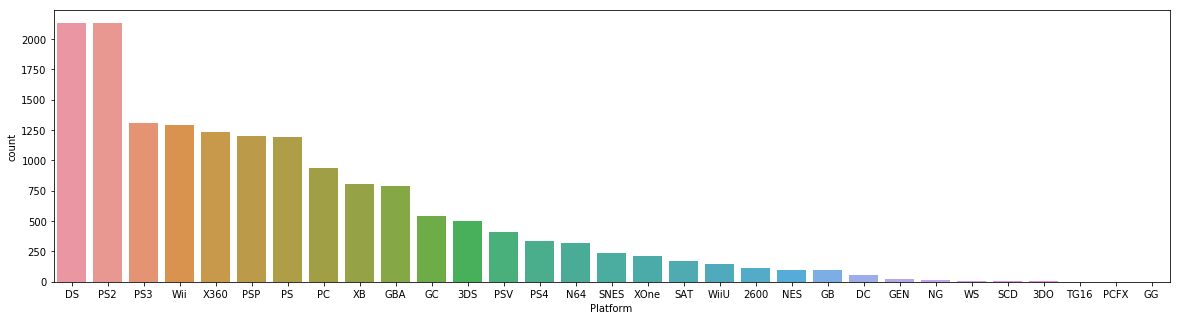

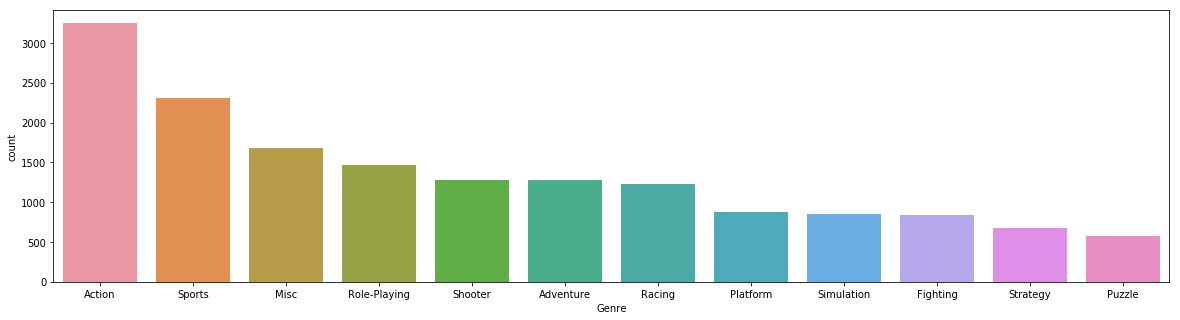

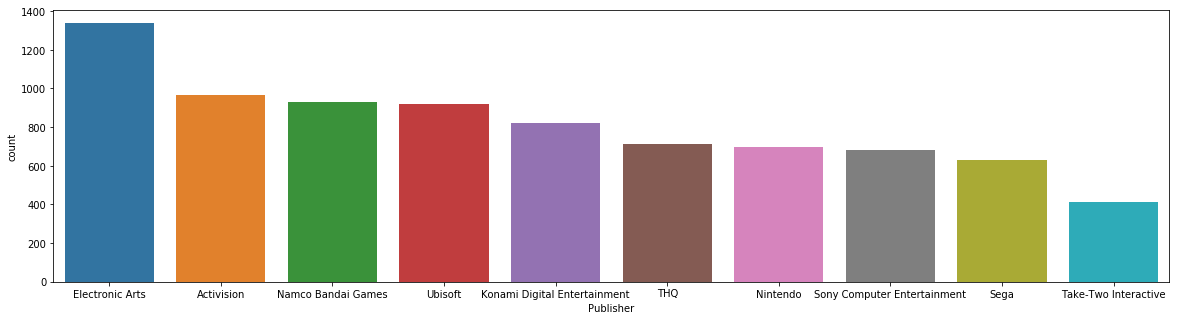

In [8]:
plt.rcParams['figure.figsize']=20,5
x=vg['Platform']
sns.countplot(x,data=vg,order=vg.Platform.value_counts().index)
plt.show()
x=vg['Genre']
sns.countplot(x,data=vg,order=vg.Genre.value_counts().index)
plt.show()
sns.countplot(x=vg['Publisher'],data=vg,order=vg.Publisher.value_counts().iloc[:10].index)
plt.show()

From the charts above, we could draw the conclusion that DS and PS2 are the platforms which have lots of games over 2000; Action, sports and misc are genres which of lots of games over 1500; Electronic Arts has games more than 1200 and Activision, Ubisoft, Konami Digital Entertainment and Namco Bandai Games are publishers which have games more than 800. 

##### For the Platform, Genre, Publisher columns
##### How is the data distributed? 
From the chart, we could see clearly Platform, Genre, Publisher columns' distribution. 
##### What are the summary statistics? 
From the chart, we could see clearly the amounts of games each platform, genre, publisher published.

##### Are there anomalies/outliers? 
On the ground that the max sales of each area are all beyond the scale, I deem that there are none outliners.

### the relation between platform and genre about the amounts of games

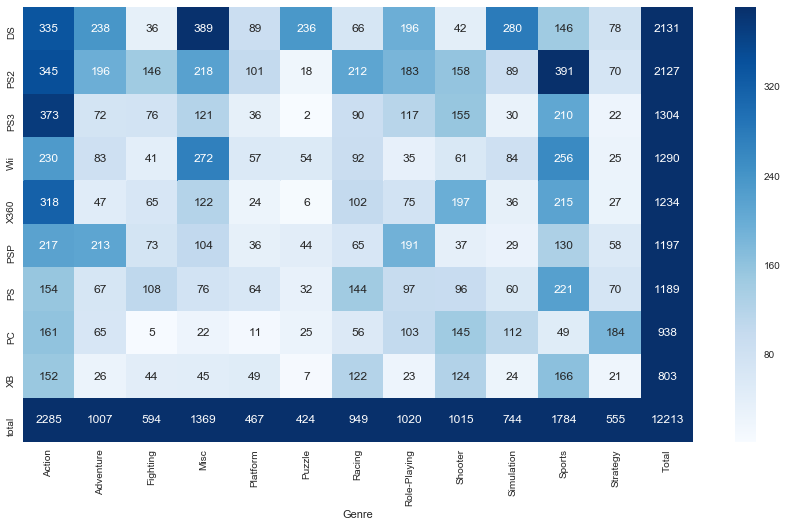

In [9]:
pg=pd.crosstab(vg.Platform,vg.Genre)
pg['Total'] = pg.sum(axis=1)
platformMostGames = pg[pg['Total']>800].sort_values(by='Total', ascending = False)
dataNeeded = platformMostGames.loc[:,:'Strategy']
vmax = dataNeeded.values.max()
vmin = dataNeeded.values.min()
platformMostGamesFinal = platformMostGames.append(pd.DataFrame(platformMostGames.sum(), columns=['total']).T, ignore_index=False)
sns.set(font_scale=1)
plt.figure(figsize=(15,8))
sns.heatmap(platformMostGamesFinal, vmin = vmin, vmax = vmax, annot=True, fmt="d",cmap='Blues')
plt.xticks(rotation = 90)
plt.show()

From the chart above, we could clearly get the information about the amounts of games of each genre on platforms which have games more than 800. For example, there are 373 action games on PS3 platform and 391 sports games on PS2 platform.

### the relation between publisher and genre about the amounts of games

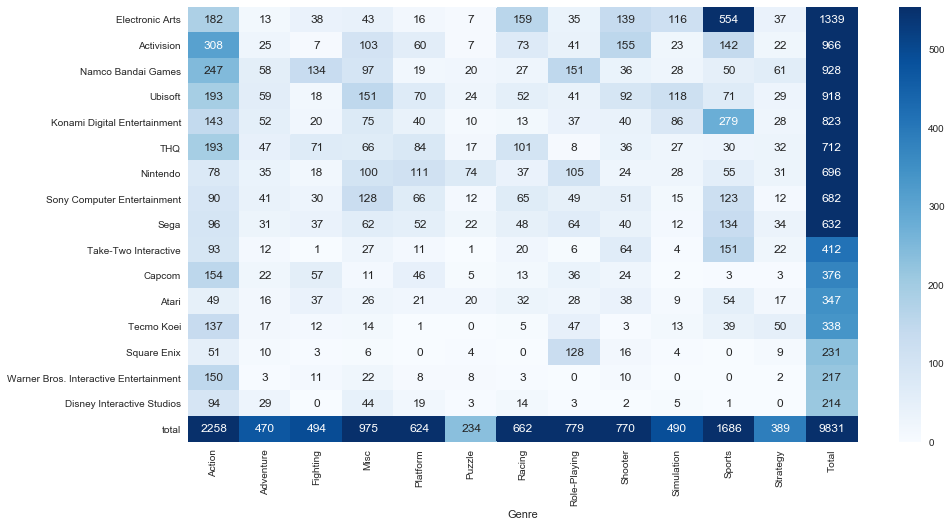

In [10]:
gp=pd.crosstab(vg.Publisher,vg.Genre)
gp['Total']=gp.sum(axis=1)
publisherMostGames= gp[gp['Total']>200].sort_values(by='Total',ascending= False)
dataNeeded= publisherMostGames.loc[:,:'Strategy']
vmax = dataNeeded.values.max()
vmin = dataNeeded.values.min()
publisherMostGamesFinal= publisherMostGames.append(pd.DataFrame(publisherMostGames.sum(),columns=['total']).T,ignore_index=False)
sns.set(font_scale=1)
plt.figure(figsize=(15,8))
sns.heatmap(publisherMostGamesFinal,vmin=vmin,vmax=vmax,annot=True,fmt="d",cmap="Blues")
plt.xticks(rotation=90)
plt.show()

From the chart above, we could clearly get the information about the amounts of games of each genre from publishers which have games more than 200. For example, Electronic Arts has published 554 sports games and Activision has published 308 action games.

### the relation between publisher and platform about the amounts of games

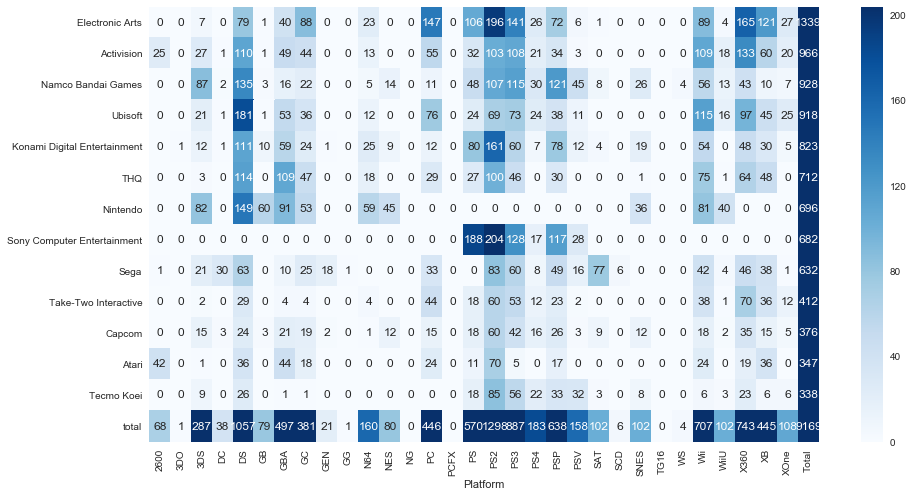

In [11]:
pp=pd.crosstab(vg.Publisher,vg.Platform)
pp['Total']=pp.sum(axis=1)
publisherMostGames2= pp[pp['Total']>300].sort_values(by='Total',ascending=False)
dataNeeded=publisherMostGames2.loc[:,:'XOne']
vmax=dataNeeded.values.max()
vmin=dataNeeded.values.min()
publisherMostGamesFinal2=publisherMostGames2.append(pd.DataFrame(publisherMostGames2.sum(),columns=['total']).T,ignore_index=False)
sns.set(font_scale=1)
plt.figure(figsize=(15,8))
sns.heatmap(publisherMostGamesFinal2,vmin=vmin,vmax=vmax,annot=True,fmt="d",cmap="Blues")
plt.xticks(rotation=90)
plt.show()

From the chart above, we could clearly get the information about the amounts of games on platforms from publishers  which have games more than 300. For example, Electronic Arts has published 165 games on X360 platform and Sony Computer Entertainment has published 204 games on PS2 platform.

## 2)The relation between platform, genre, publisher and sales
### 2.1.1The relation between genre and global sales

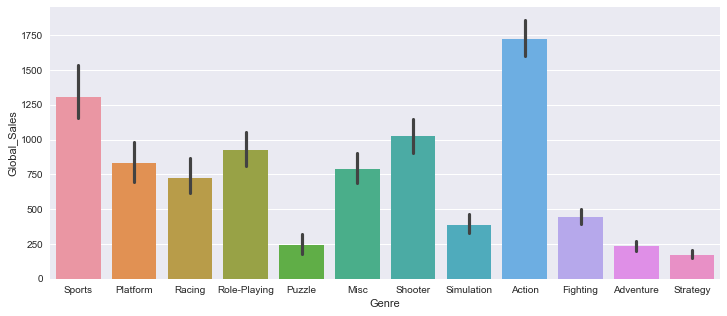

In [12]:
plt.rcParams['figure.figsize'] =12,5
x = vg['Genre']
y = vg['Global_Sales']

sns.barplot(x,y,data=vg,estimator=sum)

From the chart above, it's apparent that the most popular genres of games around the world are Action, Sports and Shooter.

### 2.1.2 The relation between publisher and global sales

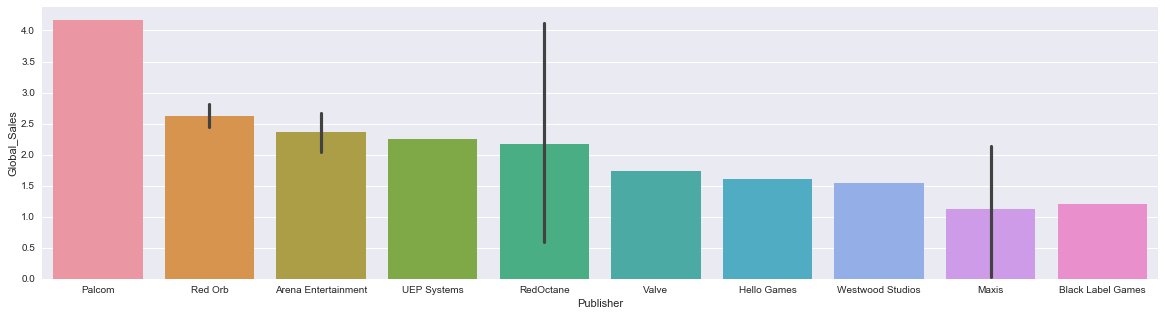

In [13]:
plt.rcParams['figure.figsize']=20,5
x = vg['Publisher']
y = vg['Global_Sales']

result=vg.groupby(['Publisher'])['Global_Sales'].aggregate(np.median).reset_index().sort_values(by='Global_Sales',ascending=False).head(10)

sns.barplot(x,y,order=result['Publisher'])


From the chart above, the conclusion is that Palcom, Red Orb and Arena Entertainment are publishers which of greatest global sales.

### 2.1.3 The relation between platform and global sales

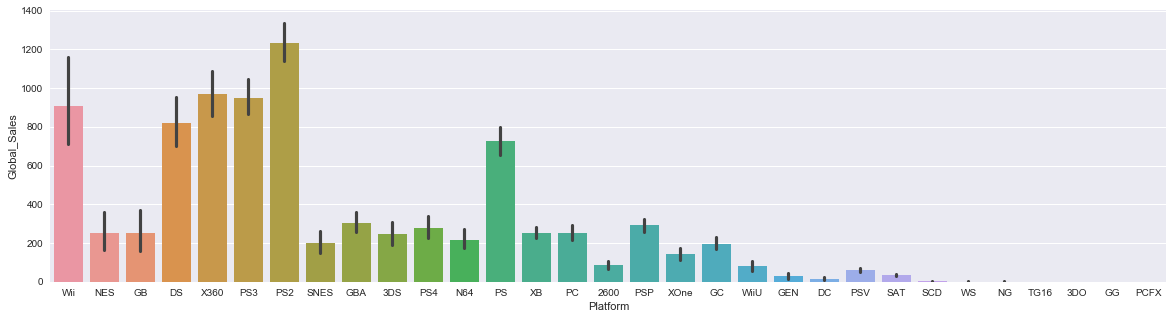

In [14]:
plt.rcParams['figure.figsize']=20,5
y=vg['Global_Sales']
x=vg['Platform']
sns.barplot(x,y,data=vg,estimator=sum)

From the chart above, the conclusion is that PS2 and Wii are platforms which of greatest global sales.

### 2.2.1 The relation between genre and sales in every area

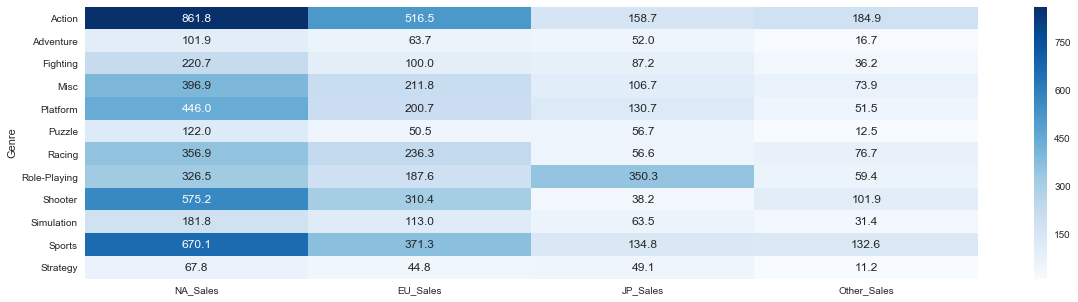

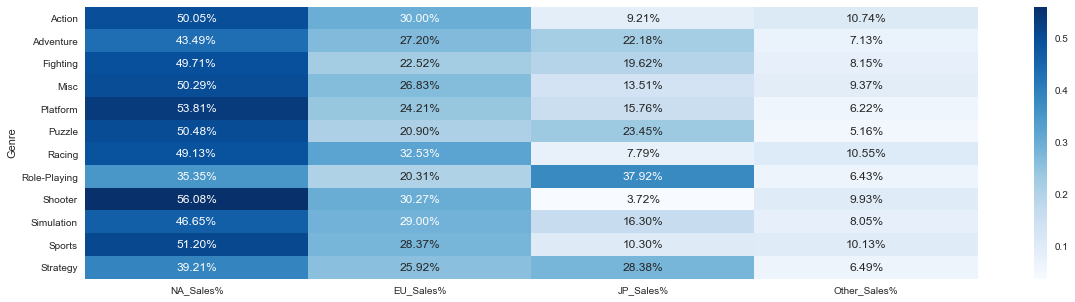

In [15]:
genreGroup= vg.groupby(['Genre']).sum().loc[:,'NA_Sales':'Global_Sales']
genreGroup['NA_Sales%']=genreGroup['NA_Sales']/genreGroup['Global_Sales']
genreGroup['EU_Sales%']=genreGroup['EU_Sales']/genreGroup['Global_Sales']
genreGroup['JP_Sales%']=genreGroup['JP_Sales']/genreGroup['Global_Sales']
genreGroup['Other_Sales%']=genreGroup['Other_Sales']/genreGroup['Global_Sales']
sns.heatmap(genreGroup.loc[:,'NA_Sales':'Other_Sales'],annot=True,fmt='.1f',cmap="Blues")
plt.show()
sns.heatmap(genreGroup.loc[:,'NA_Sales%':'Other_Sales%'],annot=True,fmt='.2%',cmap="Blues")
plt.show()

From the heatmaps above, it's obvious that games of every genre has the best sales in NA area except Role-PLaying games which is popular in JP area.

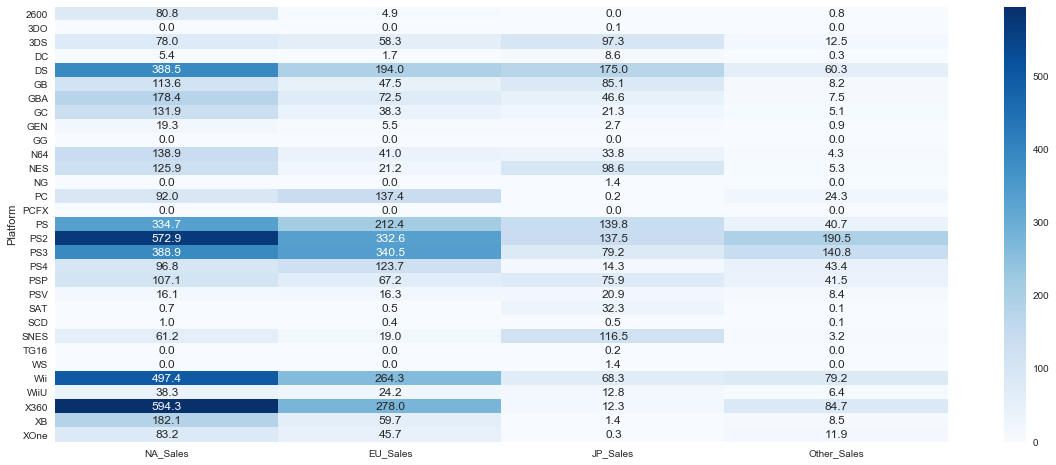

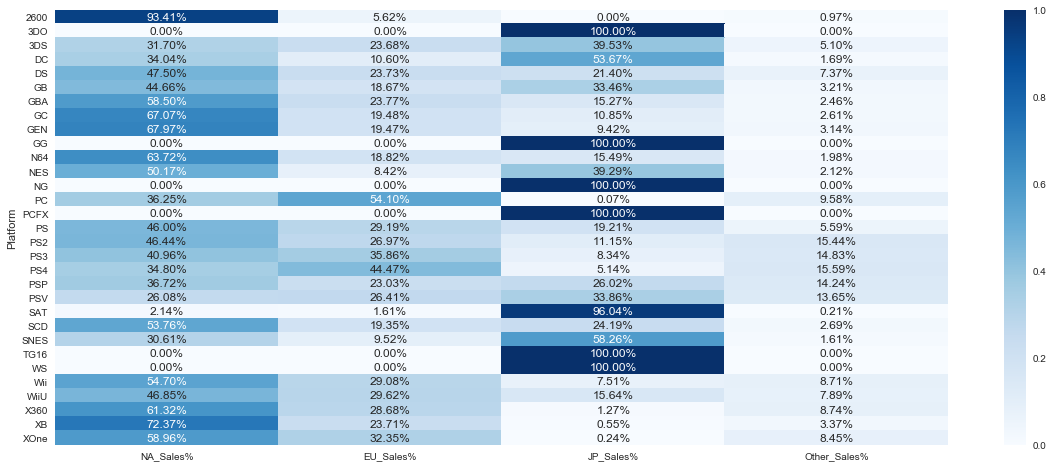

In [16]:
platformGroup=vg.groupby(['Platform']).sum().loc[:,'NA_Sales':'Global_Sales']
platformGroup['NA_Sales%']=platformGroup['NA_Sales']/platformGroup['Global_Sales']
platformGroup['EU_Sales%']=platformGroup['EU_Sales']/platformGroup['Global_Sales']
platformGroup['JP_Sales%']=platformGroup['JP_Sales']/platformGroup['Global_Sales']
platformGroup['Other_Sales%']=platformGroup['Other_Sales']/platformGroup['Global_Sales']
plt.rcParams['figure.figsize']=20,8
sns.heatmap(platformGroup.loc[:,'NA_Sales':'Other_Sales'],annot=True,fmt='.1f',cmap="Blues")
plt.show()
plt.rcParams['figure.figsize']=20,8
sns.heatmap(platformGroup.loc[:,'NA_Sales%':'Other_Sales%'],annot=True,fmt='.2%',cmap="Blues")
plt.show()

From heatmaps above,it's obvious that most platforms have the best sales in NA area. However, PC, PS4 platforms have the greatest sales in EU area. And 3DO, GG, PCFX, SAT, TG16, WS platforms nearly have 100% sales in JP area. 

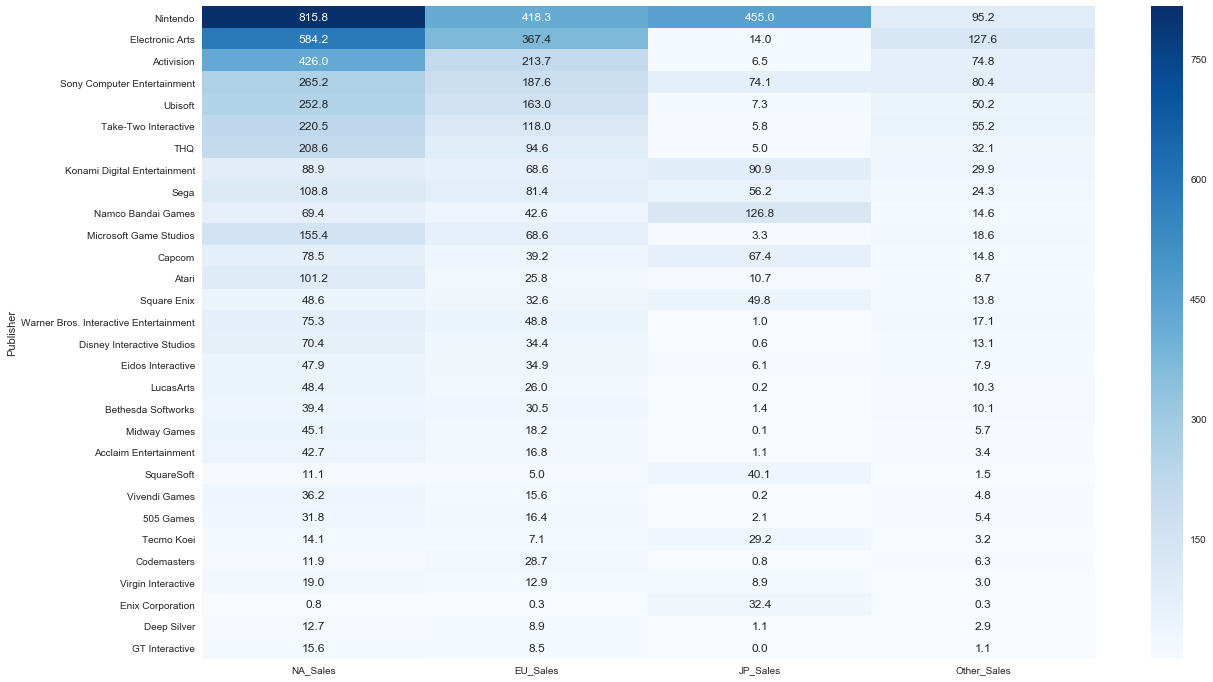

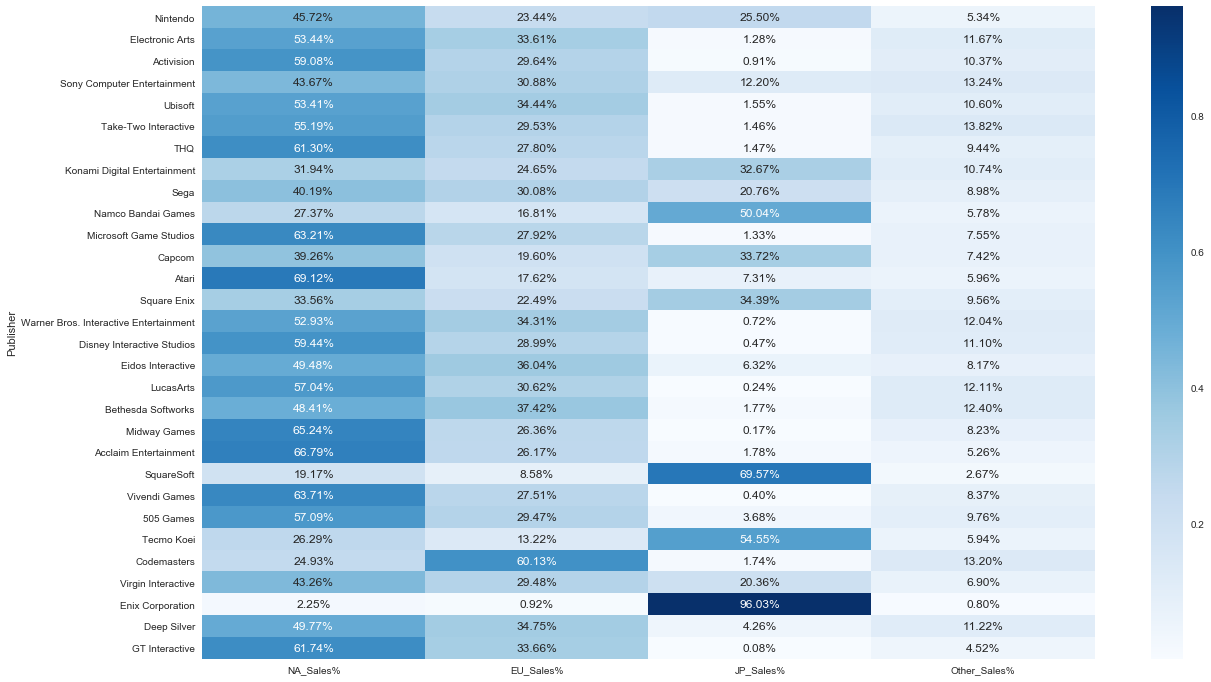

In [17]:
publisherGroup=vg.groupby(['Publisher']).sum().loc[:,'NA_Sales':'Global_Sales']
publisherGroup2=publisherGroup[publisherGroup['Global_Sales']>25].sort_values(by='Global_Sales',ascending=False)
publisherGroup2['NA_Sales%']=publisherGroup2['NA_Sales']/publisherGroup2['Global_Sales']
publisherGroup2['EU_Sales%']=publisherGroup2['EU_Sales']/publisherGroup2['Global_Sales']
publisherGroup2['JP_Sales%']=publisherGroup2['JP_Sales']/publisherGroup2['Global_Sales']
publisherGroup2['Other_Sales%']=publisherGroup2['Other_Sales']/publisherGroup2['Global_Sales']
plt.rcParams['figure.figsize']=20,12
sns.heatmap(publisherGroup2.loc[:,'NA_Sales':'Other_Sales'],annot=True,fmt='.1f',cmap="Blues")
plt.show()
plt.rcParams['figure.figsize']=20,12
sns.heatmap(publisherGroup2.loc[:,'NA_Sales%':'Other_Sales%'],annot=True,fmt='.2%',cmap="Blues")
plt.show()

From heatmaps above,it's obvious that throughout publishers with best sales, most publishers have best sales in NA Area. Simultaneously, Codemasters has greatest sales in EU area. And Namco Bandai Games, Square Enix, SquareSoft, Tecmo Koei, Enix Corporation have greatest sales in JP area.

### A clear summary of what the EDA tells me
1. info about each column    
2. colums' correlation





## Clustering

### KPrototype
#### No Scaling

In [18]:
syms=np.array(vg[['Rank','Name','Year']])
X_kprototypes=np.array(vg[['Platform','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']])
X_kprototypes[:,3:]=X_kprototypes[:,3:].astype(float)
X_kprototypes

array([['Wii', 'Sports', 'Nintendo', ..., 3.77, 8.46, 82.74000000000001],
       ['NES', 'Platform', 'Nintendo', ..., 6.81, 0.77, 40.24],
       ['Wii', 'Racing', 'Nintendo', ..., 3.79, 3.31, 35.830000000000005],
       ...,
       ['PS2', 'Racing', 'Activision', ..., 0.0, 0.0, 0.0],
       ['DS', 'Puzzle', '7G//AMES', ..., 0.0, 0.0, 0.01],
       ['GBA', 'Platform', 'Wanadoo', ..., 0.0, 0.0, 0.01]], dtype=object)

In [19]:
kprototypes_cao=KPrototypes(n_clusters=3,n_init=1,init='Cao',verbose=2)

In [20]:
clusters=kprototypes_cao.fit_predict(X_kprototypes,categorical=[0,1,2])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 769, ncost: 44925.04532543251
Run: 1, iteration: 2/100, moves: 521, ncost: 42627.53822012567
Run: 1, iteration: 3/100, moves: 419, ncost: 40682.238488508985
Run: 1, iteration: 4/100, moves: 319, ncost: 39285.19201007953
Run: 1, iteration: 5/100, moves: 243, ncost: 38269.19554765495
Run: 1, iteration: 6/100, moves: 169, ncost: 37878.506287202086
Run: 1, iteration: 7/100, moves: 136, ncost: 37547.53674684668
Run: 1, iteration: 8/100, moves: 115, ncost: 37200.098809471616
Run: 1, iteration: 9/100, moves: 102, ncost: 36955.528801976085
Run: 1, iteration: 10/100, moves: 68, ncost: 36897.52309076143
Run: 1, iteration: 11/100, moves: 38, ncost: 36881.251797270255
Run: 1, iteration: 12/100, moves: 28, ncost: 36864.95100188405
Run: 1, iteration: 13/100, moves: 24, ncost: 36855.00138615348
Run: 1, iteration: 14/100, moves: 17, ncost: 36851.489990012036
Run: 1, iteration: 15/100, moves

In [22]:
print(kprototypes_cao.cluster_centroids_)
print(kprototypes_cao.cost_)
print(kprototypes_cao.n_iter_)

[array([[ 2.12519355,  1.35322581,  0.51637097,  0.42498387,  4.41977419],
       [11.59638889,  6.46361111,  3.22833333,  1.98555556, 23.27388889],
       [ 0.16581772,  0.08538535,  0.05423089,  0.02903358,  0.33446754]]), array([['PS2', 'Action', 'Nintendo'],
       ['DS', 'Role-Playing', 'Nintendo'],
       ['DS', 'Action', 'Electronic Arts']], dtype='<U15')]
36842.88983254112
17


In [23]:
for s, c in zip(syms, clusters):
    print("Result: {}, cluster:{}".format(s, c))

Result: [1 'Wii Sports' 2006.0], cluster:1
Result: [2 'Super Mario Bros.' 1985.0], cluster:1
Result: [3 'Mario Kart Wii' 2008.0], cluster:1
Result: [4 'Wii Sports Resort' 2009.0], cluster:1
Result: [5 'Pokemon Red/Pokemon Blue' 1996.0], cluster:1
Result: [6 'Tetris' 1989.0], cluster:1
Result: [7 'New Super Mario Bros.' 2006.0], cluster:1
Result: [8 'Wii Play' 2006.0], cluster:1
Result: [9 'New Super Mario Bros. Wii' 2009.0], cluster:1
Result: [10 'Duck Hunt' 1984.0], cluster:1
Result: [11 'Nintendogs' 2005.0], cluster:1
Result: [12 'Mario Kart DS' 2005.0], cluster:1
Result: [13 'Pokemon Gold/Pokemon Silver' 1999.0], cluster:1
Result: [14 'Wii Fit' 2007.0], cluster:1
Result: [15 'Wii Fit Plus' 2009.0], cluster:1
Result: [16 'Kinect Adventures!' 2010.0], cluster:1
Result: [17 'Grand Theft Auto V' 2013.0], cluster:1
Result: [18 'Grand Theft Auto: San Andreas' 2004.0], cluster:1
Result: [19 'Super Mario World' 1990.0], cluster:1
Result: [20 'Brain Age: Train Your Brain in Minutes a Day' 20

Result: [1283 'Mass Effect 2' 2011.0], cluster:2
Result: [1284 'Major League Baseball 2K5' 2005.0], cluster:2
Result: [1285 'Fight Night 2004' 2004.0], cluster:2
Result: [1286 "Tom Clancy's Splinter Cell: Pandora Tomorrow" 2004.0], cluster:2
Result: [1287 'Imagine: Master Chef' 2007.0], cluster:2
Result: [1288 "Assassin's Creed III: Liberation" 2012.0], cluster:2
Result: [1289 'SoulCalibur IV' 2008.0], cluster:2
Result: [1290 'Mario Golf' 1999.0], cluster:2
Result: [1291 'Disney Princess' 2003.0], cluster:2
Result: [1292 'Fight Night Round 3' 2006.0], cluster:2
Result: [1293 'Metal Gear Rising: Revengeance' 2013.0], cluster:2
Result: [1294 'Chrono Trigger' 2008.0], cluster:2
Result: [1295 'Star Wars: The Force Unleashed II' 2010.0], cluster:2
Result: [1296 'The House of the Dead 2 & 3 Return' 2008.0], cluster:2
Result: [1297 'Disney Princess: Magical Jewels' 2007.0], cluster:2
Result: [1298 'LittleBigPlanet PS Vita' 2012.0], cluster:2
Result: [1299 'Xenogears' 1998.0], cluster:2
Result

Result: [2696 "Street Fighter Alpha: Warriors' Dreams" 1995.0], cluster:2
Result: [2697 'Mortal Kombat' 2012.0], cluster:2
Result: [2698 'ISS Pro Evolution' 1998.0], cluster:2
Result: [2699 'Lost Planet 2' 2010.0], cluster:2
Result: [2700 'SoulCalibur V' 2012.0], cluster:2
Result: [2701 'Portal 2' 2011.0], cluster:2
Result: [2702 'Super Monkey Ball: Touch & Roll' 2005.0], cluster:2
Result: [2703 'Pro Evolution Soccer 2015' 2014.0], cluster:2
Result: [2704 'Drawn to Life: The Next Chapter' 2009.0], cluster:2
Result: [2705 'The Lord of the Rings: Conquest' 2009.0], cluster:2
Result: [2706 'Final Fantasy II' 1988.0], cluster:2
Result: [2707 "Tony Hawk's Pro Skater 2" 2001.0], cluster:2
Result: [2708 'Taiko no Tatsujin: Tatakon de Dodon ga Don' 2002.0], cluster:2
Result: [2709 'Mega Man Battle Network 6: Cybeast Falzar / Gregar' 2005.0], cluster:2
Result: [2710 'Syphon Filter: The Omega Strain' 2004.0], cluster:2
Result: [2711 'FIFA Soccer 11' 2010.0], cluster:2
Result: [2712 'Deer Drive' 

Result: [3826 'Guinness World Records: The Videogame' 2008.0], cluster:2
Result: [3827 'The Grinch' 1999.0], cluster:2
Result: [3828 'GT Pro Series' 2006.0], cluster:2
Result: [3829 'Tales of Destiny' 2006.0], cluster:2
Result: [3830 'Spectrobes: Beyond the Portals' 2008.0], cluster:2
Result: [3831 'Classic Word Games' 2009.0], cluster:2
Result: [3832 'Naruto Shippuden: Clash of Ninja Revolution 3' 2009.0], cluster:2
Result: [3833 'Fight Night Round 3' 2006.0], cluster:2
Result: [3834 'The Golden Compass' 2007.0], cluster:2
Result: [3835 'Final Fantasy Chronicles' 2001.0], cluster:2
Result: [3836 'NBA Live 08' 2007.0], cluster:2
Result: [3837 'Syphon Filter 3' 2001.0], cluster:2
Result: [3838 'Star Wars Battlefront: Elite Squadron' 2009.0], cluster:2
Result: [3839 'Metal Gear Solid 2: Substance' 2002.0], cluster:2
Result: [3840 'We Love Katamari' 2005.0], cluster:2
Result: [3841 'NCAA Football 2003' 2002.0], cluster:2
Result: [3842 'Way of the Samurai 3' 2008.0], cluster:2
Result: [384

Result: [5258 'G-Force' 2009.0], cluster:2
Result: [5259 'NHL 2K10' 2009.0], cluster:2
Result: [5260 'Football Manager Handheld 2010' 2009.0], cluster:2
Result: [5261 'J-League Pro Soccer Club o Tsukurou!' 1999.0], cluster:2
Result: [5262 'Wonder Pets! Save the Animals!' 2008.0], cluster:2
Result: [5263 'Formula 1 Championship Edition' 1997.0], cluster:2
Result: [5264 'Shrek' 2001.0], cluster:2
Result: [5265 'CSI: Deadly Intent - The Hidden Cases' 2009.0], cluster:2
Result: [5266 'SOCOM: Tactical Strike' 2007.0], cluster:2
Result: [5267 'Blasto' 1998.0], cluster:2
Result: [5268 'Trauma Center: Second Opinion' 2006.0], cluster:2
Result: [5269 'Backyard Baseball 2006' 2005.0], cluster:2
Result: [5270 'Dark Souls III' 2016.0], cluster:2
Result: [5271 "Cabela's Outdoor Adventures (2006)" 2005.0], cluster:2
Result: [5272 'Nicktoons: Unite!' 2005.0], cluster:2
Result: [5273 'Suikoden V' 2006.0], cluster:2
Result: [5274 'Picross 2' 1996.0], cluster:2
Result: [5275 'Remember Me' 2013.0], clust

Result: [6604 'Formula One 2001' 2001.0], cluster:2
Result: [6605 'Nickelodeon Dance' 2011.0], cluster:2
Result: [6606 'Doukyuusei if' 1996.0], cluster:2
Result: [6607 "Baldur's Gate: Dark Alliance II" 2004.0], cluster:2
Result: [6608 'MVP Baseball 2004' 2004.0], cluster:2
Result: [6609 'Super Street Fighter II: Turbo Revival' 2001.0], cluster:2
Result: [6610 'Secret Weapons Over Normandy' 2003.0], cluster:2
Result: [6611
 'Combination Pro Soccer: J-League no Kantoku ni Natte Sekai wo Mezase!!'
 1998.0], cluster:2
Result: [6612 'NHL 08' 2007.0], cluster:2
Result: [6613 'Kidou Senshi Gundam: Giren no Yabou' 1998.0], cluster:2
Result: [6614 'Imagine: Ballet Star' 2008.0], cluster:2
Result: [6615 'Teen Titans' 2006.0], cluster:2
Result: [6616 'Percy Jackson and the Olympians: The Lightning Thief' 2010.0], cluster:2
Result: [6617 'Spelling Challenges and more!' 2007.0], cluster:2
Result: [6618 'Crusaders of Might and Magic' 1999.0], cluster:2
Result: [6619 'Journey' 2012.0], cluster:2
Resu

Result: [7857 'Rango: The Video Game' 2011.0], cluster:2
Result: [7858 'The Amazing Spider-Man (Console Version)' 2012.0], cluster:2
Result: [7859
 'Boku no Natsuyasumi 4: Seitouchi Shounen Tanteidan, Boku to Himitsu no Chizu'
 2009.0], cluster:2
Result: [7860 'Hyperdevotion Noire: Goddess Black Heart' 2014.0], cluster:2
Result: [7861 'Hexen' 1996.0], cluster:2
Result: [7862 'Mace: The Dark Age' 1997.0], cluster:2
Result: [7863 'AeroFighters Assault' 1997.0], cluster:2
Result: [7864 'Puyo Puyo Sun 64' 1997.0], cluster:2
Result: [7865 'Chou-Kuukan Night Pro Yakyuu King (weekly JP sales)' 1996.0], cluster:2
Result: [7866 'Quake' 1998.0], cluster:2
Result: [7867 "Sesame Street: Elmo's Number Journey" 1999.0], cluster:2
Result: [7868 'Disney Magic World 2' 2015.0], cluster:2
Result: [7869 'Squeeballs Party' 2009.0], cluster:2
Result: [7870 'Tottadoo! Yoiko no Mujintou Seikatsu' 2008.0], cluster:2
Result: [7871 "Where's Waldo? The Fantastic Journey" 2009.0], cluster:2
Result: [7872 'Family 

Result: [9436 'Wantame Music Channel: Doko Demo Style' 2007.0], cluster:2
Result: [9437 "Disney's Winnie the Pooh's Rumbly Tumbly Adventure" 2005.0], cluster:2
Result: [9438 'Shaman King: Power of Spirit' 2004.0], cluster:2
Result: [9439 'Eat Lead: The Return of Matt Hazard' 2009.0], cluster:2
Result: [9440 'Attack on Titan (KOEI)' 2016.0], cluster:2
Result: [9441 'Soccer Tsuku DS: World Challenge 2010' 2010.0], cluster:2
Result: [9442 'Family Fortunes' 2009.0], cluster:2
Result: [9443 'Megamind: The Blue Defender' 2010.0], cluster:2
Result: [9444 'Contra III: The Alien Wars' 1992.0], cluster:2
Result: [9445 'Dead to Rights: Reckoning' 2005.0], cluster:2
Result: [9446 'The BIGS 2' 2009.0], cluster:2
Result: [9447 'Slime MoriMori Dragon Quest 3: Taikaizoku to Shippo Dan' 2011.0], cluster:2
Result: [9448 'Amagami' 2009.0], cluster:2
Result: [9449 'Diablo II' 2000.0], cluster:2
Result: [9450 'How to Train Your Dragon 2' 2014.0], cluster:2
Result: [9451 'NBA 08' 2007.0], cluster:2
Result: 

Result: [10453 'Banjo-Pilot' 2005.0], cluster:2
Result: [10454 'Family Feud: 2012 Edition' 2011.0], cluster:2
Result: [10455 'Gallop Racer 2006' 2005.0], cluster:2
Result: [10456 'Army Corps of Hell' 2011.0], cluster:2
Result: [10457 'Frogger: Ancient Shadow' 2005.0], cluster:2
Result: [10458 'Digimon Story: Lost Evolution' 2010.0], cluster:2
Result: [10459 'Exit DS' 2008.0], cluster:2
Result: [10460 'Ski-Doo Snowmobile Challenge' 2009.0], cluster:2
Result: [10461 'Universe at War: Earth Assault' 2008.0], cluster:2
Result: [10462 'Despicable Me: The Game' 2010.0], cluster:2
Result: [10463 'Metal Arms: Glitch in the System' 2003.0], cluster:2
Result: [10464 'The Whispered World' 2009.0], cluster:2
Result: [10465 "Tom Clancy's Splinter Cell: Chaos Theory" 2005.0], cluster:2
Result: [10466 'Learn Chess' 2009.0], cluster:2
Result: [10468 'Escape From Monkey Island' 2001.0], cluster:2
Result: [10469 'Leisure Suit Larry: Box Office Bust' 2009.0], cluster:2
Result: [10470 'The Wolf Among Us' 

Result: [11872 'Goosebumps HorrorLand' 2008.0], cluster:2
Result: [11873 'Rugby World Cup 2015' 2015.0], cluster:2
Result: [11874 'Exhibition Volume 4' 2003.0], cluster:2
Result: [11875 'Petz Fantasy 3D' 2011.0], cluster:2
Result: [11876 'Viewpoint' 1995.0], cluster:2
Result: [11877 'Code Geass: Hangyaku no Lelouch - Lost Colors' 2008.0], cluster:2
Result: [11878 "Disney's Donald Duck Advance" 2001.0], cluster:2
Result: [11879 'Dark Souls' 2012.0], cluster:2
Result: [11880 'Stacked with Daniel Negreanu' 2006.0], cluster:2
Result: [11881 'Hakuouki: Yuugi Roku' 2010.0], cluster:2
Result: [11882 'Circus Maximus: Chariot Wars' 2002.0], cluster:2
Result: [11883 'Mega Man Battle Network 5: Double Team DS (US sales)' 2005.0], cluster:2
Result: [11884 'Kenyuu Densetsu Yaiba' 1994.0], cluster:2
Result: [11885 'SNK Arcade Classics Vol. 1' 2008.0], cluster:2
Result: [11886 'Kidou Senshi Gundam: Giren no Yabou - Axis no Kyoui V' 2009.0], cluster:2
Result: [11887 'Fantasia: Music Evolved' 2014.0], 

Result: [12999 "Piglet's Big Game" 2003.0], cluster:2
Result: [13000 'Lucha Libre AAA: Heroes del Ring' 2010.0], cluster:2
Result: [13001 'Pony Friends' 2007.0], cluster:2
Result: [13002 'Natural Doctrine' 2014.0], cluster:2
Result: [13003 'Pinball Hall of Fame: The Gottlieb Collection' 2005.0], cluster:2
Result: [13004 'Ferrari F355 Challenge' 2002.0], cluster:2
Result: [13005 'MorphX' 2010.0], cluster:2
Result: [13006 'Stranger of Sword City' 2015.0], cluster:2
Result: [13007 'Air Traffic Chaos' 2007.0], cluster:2
Result: [13008 'Battleship / Connect Four / Sorry! / Trouble' 2006.0], cluster:2
Result: [13009 'Prism: Light the Way' 2007.0], cluster:2
Result: [13010 'Tiny Toon Adventures: Toonenstein - Dare to Scare' 1998.0], cluster:2
Result: [13011 'TV Anime: Fairy Tale Gekitou! Madoushi Kessen' 2010.0], cluster:2
Result: [13012 'Shifters' 2002.0], cluster:2
Result: [13013 'RPG Tsukuru DS' 2010.0], cluster:2
Result: [13014 'WRC 5: FIA World Rally Championship' 2015.0], cluster:2
Resu

Result: [14293 'Flipper Critters' 2007.0], cluster:2
Result: [14294 'Medarot 9: Kabuto Ver. / Kuwagata Ver.' 2015.0], cluster:2
Result: [14295 'Monster Rancher Hop-A-Bout' 2000.0], cluster:2
Result: [14296 'Foto Showdown' 2010.0], cluster:2
Result: [14297 'Custom Beat Battle: Draglade 2' 2008.0], cluster:2
Result: [14298 'Gotouchi Kenkei DS' 2006.0], cluster:2
Result: [14300 'Accel World: Ginyoku no Kakusei' 2012.0], cluster:2
Result: [14301 'Elf Bowling 1 & 2' 2005.0], cluster:2
Result: [14302 'Men of War' 2009.0], cluster:2
Result: [14303 'Toy Shop' 2008.0], cluster:2
Result: [14304 'Metroid Prime: Federation Force' 2016.0], cluster:2
Result: [14305 'GunGriffon: Allied Strike' 2004.0], cluster:2
Result: [14306 'Stacked with Daniel Negreanu' 2006.0], cluster:2
Result: [14307 'Vitamin X Evolution' 2008.0], cluster:2
Result: [14308 'Saru! Get You! SaruSaru Daisakusen' 2007.0], cluster:2
Result: [14309 'Sonic Boom: Fire & Ice' 2016.0], cluster:2
Result: [14310 'The Flintstones: Big Troub

Result: [15849 'Psychedelica of the Black Butterfly' 2015.0], cluster:2
Result: [15850 'Final Fantasy XI: All-In-One Pack 2006' 2006.0], cluster:2
Result: [15851 'Joint Operations: Combined Arms' 2009.0], cluster:2
Result: [15852 'Poupee Girl DS 2: Elegant Mint / Sweet Pink Style' 2010.0], cluster:2
Result: [15853 'Winning Post 7: Maximum 2007' 2007.0], cluster:2
Result: [15854 'Monster Trux Offroad' 2007.0], cluster:2
Result: [15855 'Assault Suit Leynos' 2016.0], cluster:2
Result: [15856 'Dragon Booster' 2005.0], cluster:2
Result: [15857 "Germany's Next Topmodel 2011" 2011.0], cluster:2
Result: [15858 'Drakensang: The Dark Eye' 2009.0], cluster:2
Result: [15859 'Storm Lover 2nd' 2013.0], cluster:2
Result: [15860 'Kadenz fermata//Akkord:fortissimo' 2014.0], cluster:2
Result: [15861 'DuckTales: Remastered' 2013.0], cluster:2
Result: [15862 'Transformers: Prime' 2012.0], cluster:2
Result: [15863 'Contrast' 2013.0], cluster:2
Result: [15864 'Arcana Famiglia 2' 2013.0], cluster:2
Result: [

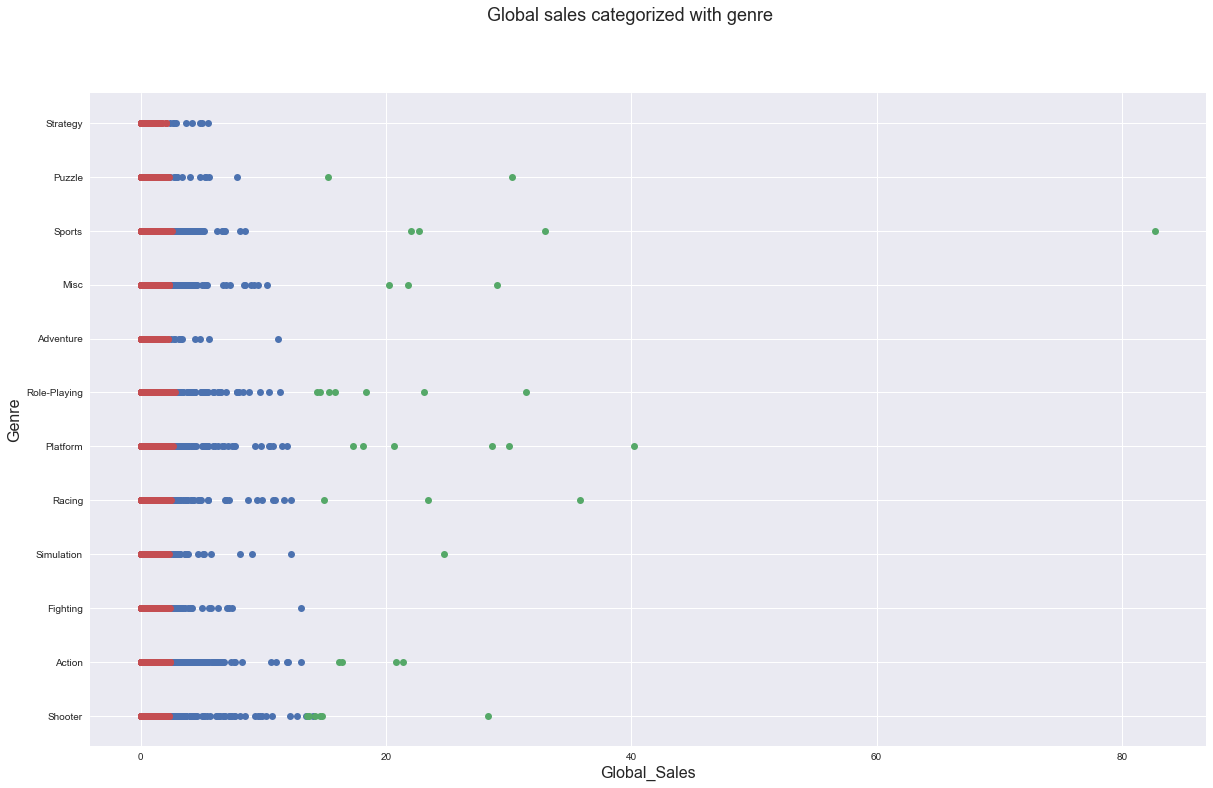

In [24]:
# Plot the results of genre
for i in set(kprototypes_cao.labels_):
    index = kprototypes_cao.labels_ == i
    plt.plot(X_kprototypes[index, 7], X_kprototypes[index, 1], 'o')
    plt.suptitle('Global sales categorized with genre', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Genre', fontsize=16)
plt.show()

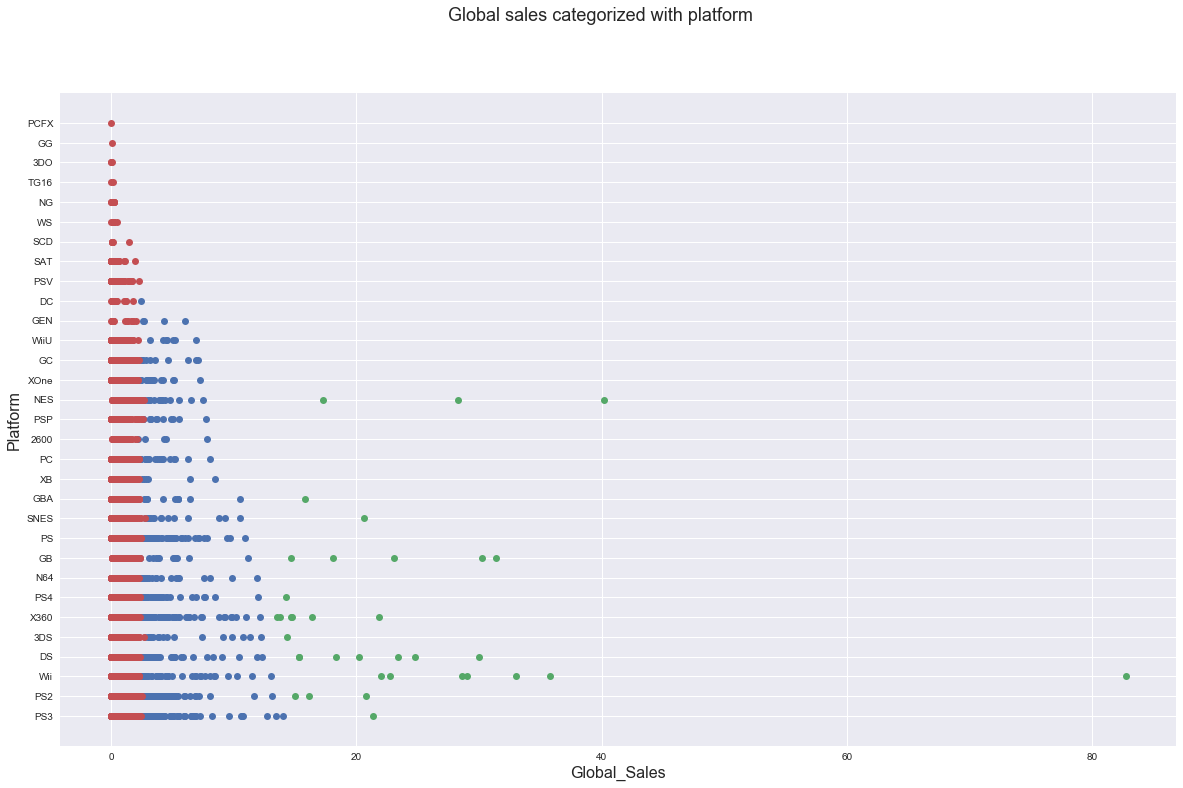

In [25]:
# Plot the results of platforms
for i in set(kprototypes_cao.labels_):
    index = kprototypes_cao.labels_ == i
    plt.plot(X_kprototypes[index, 7], X_kprototypes[index, 0], 'o')
    plt.suptitle('Global sales categorized with platform', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Platform', fontsize=16)
plt.show()

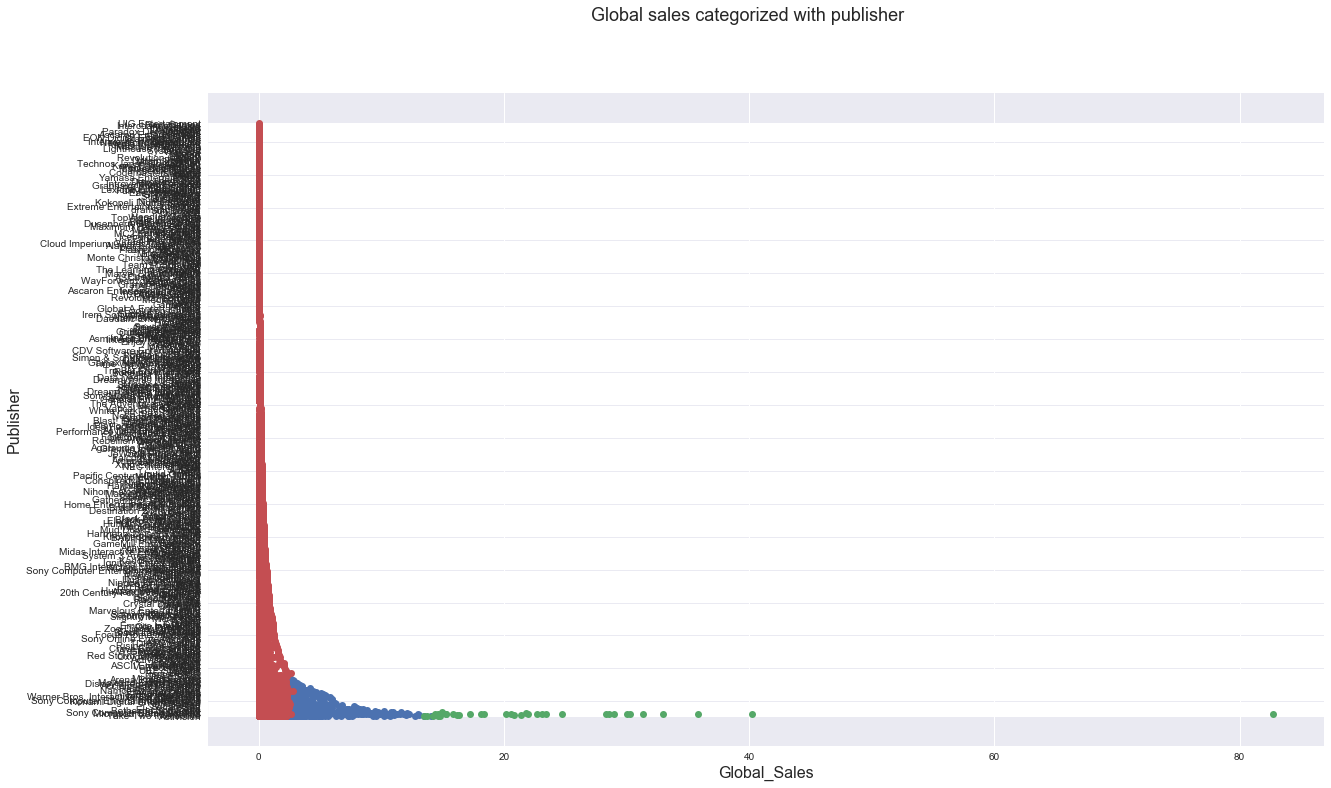

In [26]:
# Plot the results of publisher
for i in set(kprototypes_cao.labels_):
    index = kprototypes_cao.labels_ == i
    plt.plot(X_kprototypes[index, 7], X_kprototypes[index, 2], 'o')
    plt.suptitle('Global sales categorized with publisher', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Publisher', fontsize=16)
plt.show()

In [29]:
result = zip(syms, kprototypes_cao.labels_)
sortedR = sorted(result, key=lambda x: x[1])
print(sortedR)

[(array([532, 'Dragon Quest V: Tenkuu no Hanayome', 1992.0], dtype=object), 0), (array([562, 'Yokai Watch 2 Shinuchi', 2014.0], dtype=object), 0), (array([574, 'Super Mario Bros.: The Lost Levels', 1986.0], dtype=object), 0), (array([596, 'Monster Hunter Freedom 2', 2007.0], dtype=object), 0), (array([603, 'Dragon Warrior II', 1987.0], dtype=object), 0), (array([612, 'Dragon Warrior', 1986.0], dtype=object), 0), (array([615, 'PES 2009: Pro Evolution Soccer', 2008.0], dtype=object), 0), (array([630, 'Final Fantasy V', 1992.0], dtype=object), 0), (array([631, 'Final Fantasy Tactics', 1997.0], dtype=object), 0), (array([634, 'Need for Speed Carbon: Own the City', 2006.0], dtype=object), 0), (array([640, 'pro evolution soccer 2011', 2010.0], dtype=object), 0), (array([643, 'Dino Crisis', 1998.0], dtype=object), 0), (array([645, 'Need for Speed: ProStreet', 2007.0], dtype=object), 0), (array([648, 'Pro Wrestling', 1987.0], dtype=object), 0), (array([651, 'Need for Speed (2015)', 2015.0], dt

#### Scaling

In [27]:
X_train=np.array(vg[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']])
X_scaled=preprocessing.scale(X_train)
X_scaled

array([[50.1264692 , 56.69151539, 11.83559739, 44.25350057, 52.44271815],
       [35.03661496,  6.73935664, 21.58325092,  3.79621821, 25.32796392],
       [18.94968736, 25.00016939, 11.89972669, 17.15922174, 22.51440942],
       ...,
       [-0.32301125, -0.29007451, -0.25277557, -0.25477105, -0.34492338],
       [-0.32301125, -0.27043923, -0.25277557, -0.25477105, -0.33854344],
       [-0.31085182, -0.29007451, -0.25277557, -0.25477105, -0.33854344]])

In [28]:
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[-0.  0. -0. -0.  0.]
[1. 1. 1. 1. 1.]


In [29]:
X_catego=vg[['Platform','Genre','Publisher']]
X_kproto=np.concatenate((X_catego,X_scaled),axis=1)
X_kproto[:,3:]=X_kproto[:,3:].astype(float)


In [30]:
kproto_cao=KPrototypes(n_clusters=3,n_init=1,init='Cao',verbose=2)

In [31]:
clus=kproto_cao.fit_predict(X_kproto,categorical=[0,1,2])

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4345, ncost: 69761.69230923711
Run: 1, iteration: 2/100, moves: 1706, ncost: 67541.48487978315
Run: 1, iteration: 3/100, moves: 1116, ncost: 65416.34110906161
Run: 1, iteration: 4/100, moves: 730, ncost: 63334.56542469965
Run: 1, iteration: 5/100, moves: 516, ncost: 61636.946790602764
Run: 1, iteration: 6/100, moves: 370, ncost: 60707.20351489411
Run: 1, iteration: 7/100, moves: 243, ncost: 60111.867498671585
Run: 1, iteration: 8/100, moves: 168, ncost: 59657.28337387077
Run: 1, iteration: 9/100, moves: 135, ncost: 59377.49630656044
Run: 1, iteration: 10/100, moves: 69, ncost: 59326.23295894347
Run: 1, iteration: 11/100, moves: 45, ncost: 59282.577008175525
Run: 1, iteration: 12/100, moves: 43, ncost: 59193.93329241121
Run: 1, iteration: 13/100, moves: 22, ncost:

In [32]:
print(kproto_cao.cluster_centroids_)
print(kproto_cao.cost_)
print(kproto_cao.n_iter_)

[array([[13.31465948, 12.39768405, 11.0074133 , 11.40215723, 14.58724013],
       [ 2.23994559,  2.53503344,  1.60585101,  2.19819338,  2.58505668],
       [-0.11125419, -0.11995046, -0.08302202, -0.10546662, -0.12665736]]), array([['DS', 'Role-Playing', 'Nintendo'],
       ['PS2', 'Action', 'Nintendo'],
       ['DS', 'Action', 'Electronic Arts']], dtype='<U15')]
59101.8171980733
18


In [33]:
for s, c in zip(syms, clus):
    print("Result: {}, cluster:{}".format(s, c))

Result: [1 'Wii Sports' 2006.0], cluster:0
Result: [2 'Super Mario Bros.' 1985.0], cluster:0
Result: [3 'Mario Kart Wii' 2008.0], cluster:0
Result: [4 'Wii Sports Resort' 2009.0], cluster:0
Result: [5 'Pokemon Red/Pokemon Blue' 1996.0], cluster:0
Result: [6 'Tetris' 1989.0], cluster:0
Result: [7 'New Super Mario Bros.' 2006.0], cluster:0
Result: [8 'Wii Play' 2006.0], cluster:0
Result: [9 'New Super Mario Bros. Wii' 2009.0], cluster:0
Result: [10 'Duck Hunt' 1984.0], cluster:0
Result: [11 'Nintendogs' 2005.0], cluster:0
Result: [12 'Mario Kart DS' 2005.0], cluster:0
Result: [13 'Pokemon Gold/Pokemon Silver' 1999.0], cluster:0
Result: [14 'Wii Fit' 2007.0], cluster:0
Result: [15 'Wii Fit Plus' 2009.0], cluster:0
Result: [16 'Kinect Adventures!' 2010.0], cluster:0
Result: [17 'Grand Theft Auto V' 2013.0], cluster:0
Result: [18 'Grand Theft Auto: San Andreas' 2004.0], cluster:0
Result: [19 'Super Mario World' 1990.0], cluster:0
Result: [20 'Brain Age: Train Your Brain in Minutes a Day' 20

Result: [1379 'Twisted Metal: Black' 2001.0], cluster:2
Result: [1380 'NASCAR 2005: Chase for the Cup' 2004.0], cluster:2
Result: [1381 'Call of Duty: Black Ops' 2010.0], cluster:2
Result: [1382 'Spider-Man: The Movie' 2002.0], cluster:2
Result: [1383 'Need For Speed: Undercover' 2008.0], cluster:2
Result: [1384 '2Xtreme' 1996.0], cluster:2
Result: [1385 'Far Cry 2' 2008.0], cluster:2
Result: [1386 'Sonic Advance 3' 2004.0], cluster:2
Result: [1387 'Final Fantasy III' 1990.0], cluster:2
Result: [1388 'Battlefield 4' 2013.0], cluster:2
Result: [1389 'Colin McRae Rally 3' 2002.0], cluster:2
Result: [1390 'Madden NFL 2002' 2001.0], cluster:2
Result: [1391 'Doom (2016)' 2016.0], cluster:2
Result: [1392 'Final Fantasy XII: Revenant Wings' 2007.0], cluster:2
Result: [1393 'Bakugan: Battle Brawlers' 2009.0], cluster:2
Result: [1394 'Deus Ex: Human Revolution' 2011.0], cluster:2
Result: [1395 'NBA Jam' 1994.0], cluster:2
Result: [1396 'Teenage Mutant Ninja Turtles III: The Manhattan Project' 1

Result: [2636 'Doom' 1994.0], cluster:2
Result: [2637 'Buzz! The Hollywood Quiz' 2007.0], cluster:2
Result: [2638 'Puzzler World' 2009.0], cluster:2
Result: [2639 "My Little Pony: Pinkie Pie's Party" 2008.0], cluster:2
Result: [2640 'We Sing' 2009.0], cluster:2
Result: [2641 'Marvel vs. Capcom: Clash of Super Heroes' 1999.0], cluster:2
Result: [2642 'God of War Saga' 2012.0], cluster:2
Result: [2643 'Battle Stations' 1997.0], cluster:2
Result: [2644 'Tetris Party Deluxe' 2010.0], cluster:2
Result: [2645 'Pro Evolution Soccer 2016' 2015.0], cluster:2
Result: [2646 'Worms: Open Warfare' 2006.0], cluster:2
Result: [2647 'Star Wars Battlefront: Elite Squadron' 2009.0], cluster:2
Result: [2648 'UFC Personal Trainer: The Ultimate Fitness System' 2011.0], cluster:2
Result: [2649 'Resident Evil: Operation Raccoon City' 2012.0], cluster:2
Result: [2650 'NBA 2K7' 2006.0], cluster:2
Result: [2651 'Need for Speed: ProStreet' 2008.0], cluster:2
Result: [2652 'Toy Story 3: The Video Game' 2010.0], c

Result: [3830 'Spectrobes: Beyond the Portals' 2008.0], cluster:2
Result: [3831 'Classic Word Games' 2009.0], cluster:2
Result: [3832 'Naruto Shippuden: Clash of Ninja Revolution 3' 2009.0], cluster:2
Result: [3833 'Fight Night Round 3' 2006.0], cluster:2
Result: [3834 'The Golden Compass' 2007.0], cluster:2
Result: [3835 'Final Fantasy Chronicles' 2001.0], cluster:2
Result: [3836 'NBA Live 08' 2007.0], cluster:2
Result: [3837 'Syphon Filter 3' 2001.0], cluster:2
Result: [3838 'Star Wars Battlefront: Elite Squadron' 2009.0], cluster:2
Result: [3839 'Metal Gear Solid 2: Substance' 2002.0], cluster:2
Result: [3840 'We Love Katamari' 2005.0], cluster:2
Result: [3841 'NCAA Football 2003' 2002.0], cluster:2
Result: [3842 'Way of the Samurai 3' 2008.0], cluster:2
Result: [3843 'NBA Live 09' 2008.0], cluster:2
Result: [3844 'DC Universe Online' 2011.0], cluster:2
Result: [3845 'Ready 2 Rumble Boxing: Round 2' 2000.0], cluster:2
Result: [3846 'Mega Man 6' 1993.0], cluster:2
Result: [3847 'Miss

Result: [5188 'The Incredibles: Rise of the Underminer' 2005.0], cluster:2
Result: [5189 'Spider-Man: Shattered Dimensions' 2010.0], cluster:2
Result: [5190 'BlazBlue: Calamity Trigger' 2009.0], cluster:2
Result: [5191 'MechWarrior 2: 31st Century Combat' 1997.0], cluster:2
Result: [5192 'Earth Defense Force 2025' 2013.0], cluster:2
Result: [5193 'Hamtaro: Ham-Ham Heartbreak' 2002.0], cluster:2
Result: [5194 'Okage: Shadow King' 2001.0], cluster:2
Result: [5195 'Press Your Luck 2010 Edition' 2009.0], cluster:2
Result: [5196 'Mobile Suit Z-Gundam' 1997.0], cluster:2
Result: [5199 'Speed Racer: The Videogame' 2008.0], cluster:2
Result: [5200 'NHL 2K10' 2009.0], cluster:2
Result: [5201 "Assassin's Creed III" 2012.0], cluster:2
Result: [5202 "Kirby's Dream Land 3" 1997.0], cluster:2
Result: [5203 'Big Bass World Championship' 1997.0], cluster:2
Result: [5204 'NFL GameDay 2001' 2000.0], cluster:2
Result: [5205 'NBA 2K6' 2005.0], cluster:2
Result: [5206 'Jurassic Park' 1993.0], cluster:2
Res

Result: [6473 'J Stars Victory Vs.' 2014.0], cluster:2
Result: [6474 'Rugrats: I Gotta Go Party' 2002.0], cluster:2
Result: [6475 'Virtua Racing' 1994.0], cluster:2
Result: [6476 'Crash Tag Team Racing' 2005.0], cluster:2
Result: [6477 'Prison Break: The Conspiracy' 2010.0], cluster:2
Result: [6478 'Bolt' 2008.0], cluster:2
Result: [6479 'DS Bungaku Zenshuu' 2007.0], cluster:2
Result: [6480 'We Cheer 2' 2009.0], cluster:2
Result: [6481 'Nancy Drew: The Mystery of the Clue Bender Society' 2008.0], cluster:2
Result: [6482 'Inazuma Eleven GO 3: Galaxy' 2013.0], cluster:2
Result: [6483 'Ford Racing 3' 2004.0], cluster:2
Result: [6484 'Michael Jackson: The Experience' 2010.0], cluster:2
Result: [6485 'Phantasy Star Universe: Ambition of the Illuminus' 2007.0], cluster:2
Result: [6486 'Project Runway' 2010.0], cluster:2
Result: [6487 'Jikkyou Powerful Pro Yakyuu 2013' 2013.0], cluster:2
Result: [6488 'The Adventures of Jimmy Neutron Boy Genius vs. Jimmy Negatron'
 2002.0], cluster:2
Result: 

Result: [8003 'Dance Dance Revolution: Disney Grooves' 2009.0], cluster:2
Result: [8004 'Pure Futbol' 2010.0], cluster:2
Result: [8005 'Harvest Moon: A Wonderful Life Special Edition' 2004.0], cluster:2
Result: [8006 'Sports Illustrated for Kids: Football' 2003.0], cluster:2
Result: [8007 'The Last Airbender' 2010.0], cluster:2
Result: [8008 'Happy Cooking' 2006.0], cluster:2
Result: [8009 '.hack//Quarantine Part 4: The Final Chapter' 2003.0], cluster:2
Result: [8010 'Close Combat: First to Fight' 2005.0], cluster:2
Result: [8011 'MotoGP 14' 2014.0], cluster:2
Result: [8012 "Indiana Jones and the Emperor's Tomb" 2003.0], cluster:2
Result: [8013 'NBA Live 08' 2007.0], cluster:2
Result: [8014 'Buffy the Vampire Slayer: Chaos Bleeds' 2003.0], cluster:2
Result: [8015 'Half-Minute Hero' 2009.0], cluster:2
Result: [8016 'Rock Band Track Pack Volume 2' 2008.0], cluster:2
Result: [8017 'Reel Fishing II' 2000.0], cluster:2
Result: [8018 'Ringling Bros. and Barnum & Bailey Circus' 2009.0], clust

Result: [9534 'Metal Max 3' 2010.0], cluster:2
Result: [9535 'Rock Band Track Pack Volume 1' 2008.0], cluster:2
Result: [9536 'Puyo Puyo!! 20th Anniversary' 2011.0], cluster:2
Result: [9537 'Hour of Victory' 2007.0], cluster:2
Result: [9538 'Namco Soccer Prime Goal' 1995.0], cluster:2
Result: [9539 'NBA 08' 2007.0], cluster:2
Result: [9540 "Dragon Quest Heroes II: Twin Kings and the Prophecy's End" 2016.0], cluster:2
Result: [9541 'Monster Hunter Frontier Online' 2010.0], cluster:2
Result: [9542 'Green Lantern: Rise of the Manhunters' 2011.0], cluster:2
Result: [9543 'Shin Megami Tensei: Digital Devil Saga' 2004.0], cluster:2
Result: [9544 '7 Wonders of the Ancient World' 2007.0], cluster:2
Result: [9545 "Backyard Baseball '09" 2008.0], cluster:2
Result: [9546 'Puppies 3D' 2011.0], cluster:2
Result: [9547 'Jissen Pachi-Slot Hisshouhou! Aladdin II Evolution' 2005.0], cluster:2
Result: [9548 'Mystic Ark' 1995.0], cluster:2
Result: [9549 'Just Cause 2' 2010.0], cluster:2
Result: [9550 'Ty

Result: [11058 'Winter Stars' 2011.0], cluster:2
Result: [11059 'Go Play: City Sports' 2009.0], cluster:2
Result: [11060 'Porsche Challenge' 1997.0], cluster:2
Result: [11061 'Dragon Ball Z: Shin Butouden' 1995.0], cluster:2
Result: [11062 'Beowulf: The Game' 2007.0], cluster:2
Result: [11063 'Super Robot Taisen MX Portable' 2005.0], cluster:2
Result: [11064 'Mimana Iyar Chronicle' 2009.0], cluster:2
Result: [11065 'Detana TwinBee Yahho! Deluxe Pack' 1995.0], cluster:2
Result: [11066 'Shin Ken to Mah? to Gakuenmono. Toki no Gakuen' 2012.0], cluster:2
Result: [11067 'Super Robot Wars OG: The Moon Dwellers' 2016.0], cluster:2
Result: [11068 'Uta no Prince-Sama: Music 2' 2013.0], cluster:2
Result: [11069 'Jambo! Safari Animal Rescue' 2009.0], cluster:2
Result: [11070 'Supreme Commander' 2008.0], cluster:2
Result: [11071 'Saiyuuki: Kinkaku, Ginkaku no Inbou' 2007.0], cluster:2
Result: [11072 'Bleach: Heat the Soul 6' 2009.0], cluster:2
Result: [11073 'Roary the Racing Car' 2009.0], cluster

Result: [12585 'Mercury Meltdown' 2006.0], cluster:2
Result: [12586 'SingStar Mallorca Party' 2009.0], cluster:2
Result: [12587 '3D Lemmings' 1995.0], cluster:2
Result: [12588 'Hi Hi Puffy AmiYumi: Kaznapped' 2005.0], cluster:2
Result: [12589 'FIFA Soccer 07' 2006.0], cluster:2
Result: [12590 'Resident Evil - Code: Veronica X' 2003.0], cluster:2
Result: [12591 'Broken Sword: The Shadow of the Templars' 2002.0], cluster:2
Result: [12592 'Back to the Future: The Game' 2011.0], cluster:2
Result: [12593 'Summon Night 6: Lost Borders' 2016.0], cluster:2
Result: [12594 'Tenchi Muyou! Ryoukouki Gokuraku' 1995.0], cluster:2
Result: [12595 "Kelly Slater's Pro Surfer" 2002.0], cluster:2
Result: [12596 "Jacqueline Wilson's Tracy Beaker: The Game" 2009.0], cluster:2
Result: [12597 'Sacred 3' 2014.0], cluster:2
Result: [12598 'I Am In The Movie' 2012.0], cluster:2
Result: [12599 'Doraemon: Nobita no Uchuu Eiyuuki' 2015.0], cluster:2
Result: [12600 'Trapt' 2005.0], cluster:2
Result: [12601 'Jewel Le

Result: [14110 'DoraMoji: Nobita no Kanji Daisakusen' 2015.0], cluster:2
Result: [14111 'Gekiatsu!! Pachi Game Tamashi: CR Evangelion - Hajimari no Fukuin'
 2010.0], cluster:2
Result: [14112 'Supreme Ruler: Cold War' 2011.0], cluster:2
Result: [14113 'Travel Coach: Europe 1' 2008.0], cluster:2
Result: [14114 'Top Gun: Hard Lock' 2012.0], cluster:2
Result: [14115 'MX World Tour Featuring Jamie Little' 2005.0], cluster:2
Result: [14116 'XBLAZE Code: Embryo' 2013.0], cluster:2
Result: [14117 'The Idolmaster: Gravure For You! Vol. 4' 2012.0], cluster:2
Result: [14118 'RedCard 20-03' 2002.0], cluster:2
Result: [14119 'Katekyoo Hitman Reborn! DS: Fate of Heat II - Unmei no Futari'
 2009.0], cluster:2
Result: [14120 'Puyo Puyo 7' 2009.0], cluster:2
Result: [14121 'Asterix & Obelix: Kick Buttix' 2004.0], cluster:2
Result: [14122 'Radiant Silvergun' 1998.0], cluster:2
Result: [14123 'Bounty Hounds' 2006.0], cluster:2
Result: [14124 'Care Bears - Care Quest' 2005.0], cluster:2
Result: [14125 'Ap

Result: [15640 'RoboCop' 2003.0], cluster:2
Result: [15641 'Elminage II: Sousei no Megami to Unmei no Daichi' 2009.0], cluster:2
Result: [15642 'Lara Croft and the Temple of Osiris' 2014.0], cluster:2
Result: [15643 'Final Fantasy XIV: Heavensward' 2015.0], cluster:2
Result: [15644 'Grisaia no Rakuen: Le Eden de la Grisaia' 2014.0], cluster:2
Result: [15645 'Blazing Souls' 2006.0], cluster:2
Result: [15646 'Seinaru Kana: Orichalcum no Na no Motoni' 2012.0], cluster:2
Result: [15647 'NHL 2K3' 2002.0], cluster:2
Result: [15648 'PDC World Championship Darts 2009' 2009.0], cluster:2
Result: [15649 'Tour de France 2014' 2014.0], cluster:2
Result: [15650 'The Hustle: Detroit Streets' 2006.0], cluster:2
Result: [15651 'Tail of the Sun' 1996.0], cluster:2
Result: [15652 'Canada Hunt' 2010.0], cluster:2
Result: [15653 "Space Channel 5: Ulala's Cosmic Attack" 2002.0], cluster:2
Result: [15654 'Airline Tycoon' 2000.0], cluster:2
Result: [15656 'Disney Sports Basketball' 2002.0], cluster:2
Result:

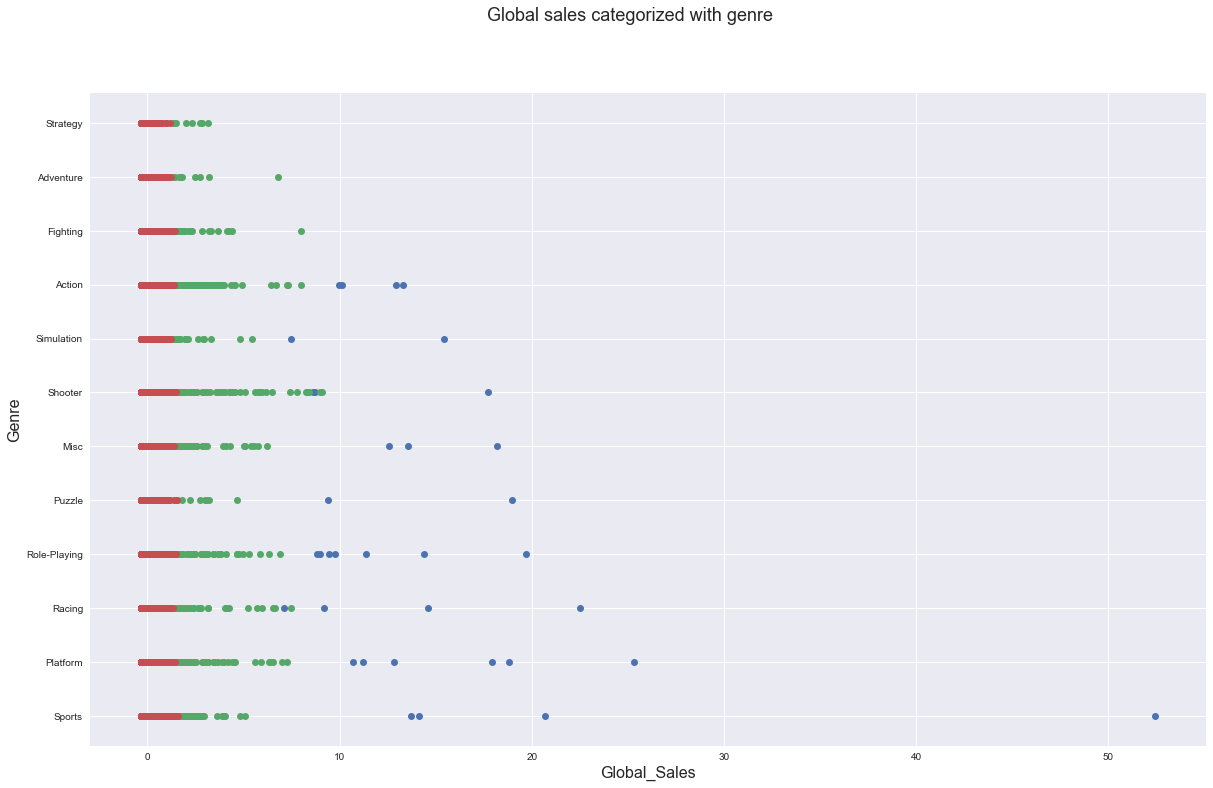

In [34]:
# Plot the results of genre
for i in set(kproto_cao.labels_):
    index = kproto_cao.labels_ == i
    plt.plot(X_kproto[index, 7], X_kprototypes[index, 1], 'o')
    plt.suptitle('Global sales categorized with genre', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Genre', fontsize=16)
plt.show()

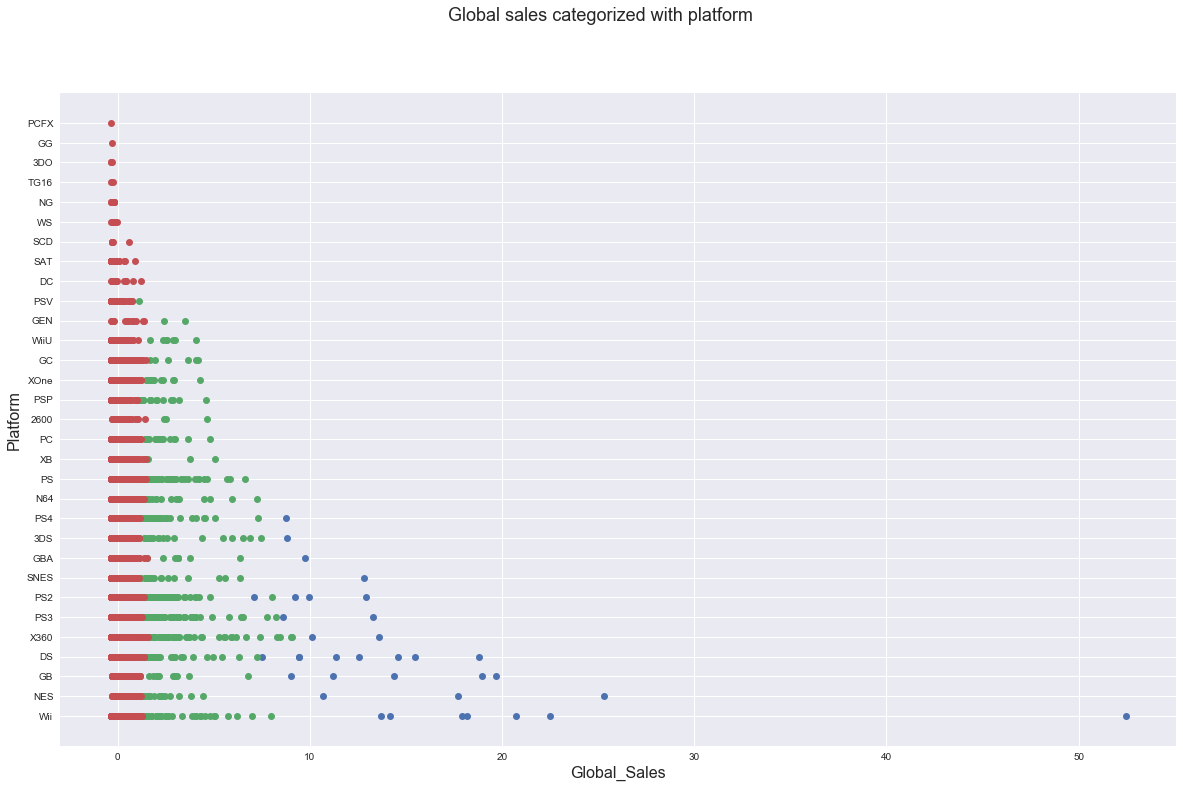

In [35]:
# Plot the results of platforms
for i in set(kproto_cao.labels_):
    index = kproto_cao.labels_ == i
    plt.plot(X_kproto[index, 7], X_kproto[index, 0], 'o')
    plt.suptitle('Global sales categorized with platform', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Platform', fontsize=16)
plt.show()

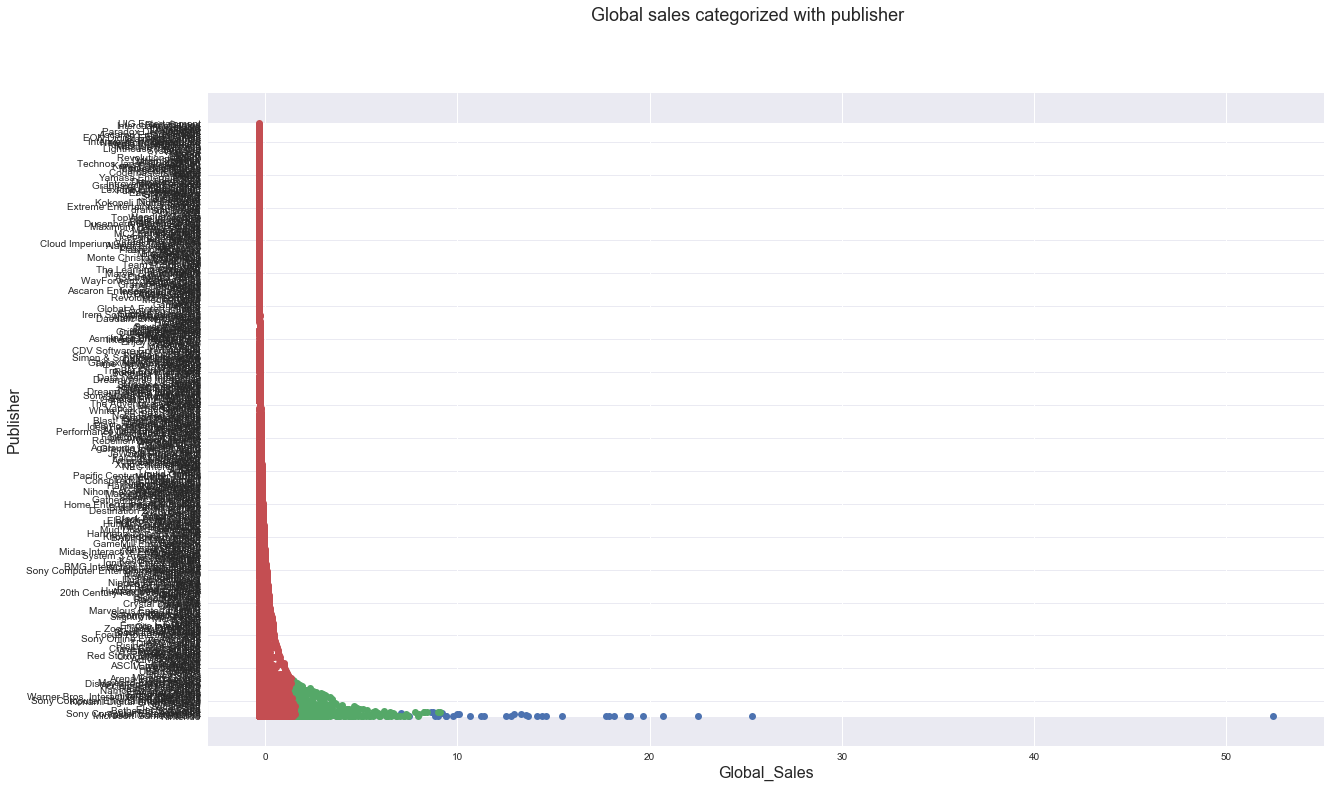

In [37]:
# Plot the results of publisher
for i in set(kproto_cao.labels_):
    index = kproto_cao.labels_ == i
    plt.plot(X_kproto[index, 7], X_kproto[index, 2], 'o')
    plt.suptitle('Global sales categorized with publisher', fontsize=18)
    plt.xlabel('Global_Sales', fontsize=16)
    plt.ylabel('Publisher', fontsize=16)
plt.show()

In [36]:
resul = zip(syms, kproto_cao.labels_)
sortedRe = sorted(resul, key=lambda x: x[1])
print(sortedRe)

[(array([1, 'Wii Sports', 2006.0], dtype=object), 0), (array([2, 'Super Mario Bros.', 1985.0], dtype=object), 0), (array([3, 'Mario Kart Wii', 2008.0], dtype=object), 0), (array([4, 'Wii Sports Resort', 2009.0], dtype=object), 0), (array([5, 'Pokemon Red/Pokemon Blue', 1996.0], dtype=object), 0), (array([6, 'Tetris', 1989.0], dtype=object), 0), (array([7, 'New Super Mario Bros.', 2006.0], dtype=object), 0), (array([8, 'Wii Play', 2006.0], dtype=object), 0), (array([9, 'New Super Mario Bros. Wii', 2009.0], dtype=object), 0), (array([10, 'Duck Hunt', 1984.0], dtype=object), 0), (array([11, 'Nintendogs', 2005.0], dtype=object), 0), (array([12, 'Mario Kart DS', 2005.0], dtype=object), 0), (array([13, 'Pokemon Gold/Pokemon Silver', 1999.0], dtype=object), 0), (array([14, 'Wii Fit', 2007.0], dtype=object), 0), (array([15, 'Wii Fit Plus', 2009.0], dtype=object), 0), (array([16, 'Kinect Adventures!', 2010.0], dtype=object), 0), (array([17, 'Grand Theft Auto V', 2013.0], dtype=object), 0), (arr

##### Does scaling effect the clustering? 
From the chart and results printed, it's apparent that scaling effects the clustering.
Taking Global sales categorized with platform for example, before scaling, DC's most games belong to grouping with low global sales.After scaling, DC's all games belong to grouping with low global sales.
Taking Global sales categorized with publisher for example, the scale of each grouping is clearly different.
##### Does the clustering produce interesting groupings?
Yes. From the chart, we could see interesting groupings. 

Taking Global sales categorized with genre for example, it's clearly that most concentrates in grouping with low global sales, small part concentrates in grouping with global sales between 1 to 10, very few concentrates in grouping with very high global sales.

Taking Global sales categorized with platform for example, it's clearly that most concentrates in grouping with low global sales(especially PCFX, GG, 3DO, TG16, NG, WS, SCD, SAT, DC platforms only have low global sales), small part concentrates in grouping with global sales between 1 to 10, very few concentrates in grouping with very high global sales.

Taking Global sales categorized with publisher for example, it's clearly that most concentrates in grouping with low global sales, small part concentrates in grouping with global sales between 1 to 10, very few concentrates in grouping with very high global sales.

### KMeans
#### No Scaling

In [108]:
vgKMeans=vg.copy()

In [40]:
clmns=['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']

In [41]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(vgKMeans[clmns])
labels = kmeans.labels_
labels

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [42]:
#Glue back to originaal data
vgKMeans['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

vgKMeansNew=vgKMeans[clmns]
vgKMeansNew

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  clusters
0         41.49     29.02      3.77         8.46         82.74         2
1         29.08      3.58      6.81         0.77         40.24         2
2         15.85     12.88      3.79         3.31         35.83         2
3         15.75     11.01      3.28         2.96         33.00         2
4         11.27      8.89     10.22         1.00         31.38         2
5         23.20      2.26      4.22         0.58         30.26         2
6         11.38      9.23      6.50         2.90         30.01         2
7         14.03      9.20      2.93         2.85         29.01         2
8         14.59      7.06      4.70         2.26         28.61         2
9         26.93      0.63      0.28         0.47         28.31         2
10         9.07     11.00      1.93         2.75         24.75         2
11         9.81      7.57      4.13         1.92         23.43         2
12         9.00      6.18      7.20         0.71         23.09         2
13         8.94      8.03      3.60         2.15         22.72         2
14         9.09      8.59      2.53         1.79         22.00         2
15        14.97      4.94      0.24         1.67         21.82         2
16         7.01      9.27      0.97         4.14         21.39         2
17         9.43      0.40      0.41        10.57         20.81         1
18        12.78      3.75      3.54         0.55         20.62         2
19         4.75      9.26      4.16         2.05         20.22         1
20         6.42      4.52      6.04         1.37         18.35         1
21        10.83      2.71      4.18         0.42         18.14         1
22         9.54      3.44      3.84         0.46         17.28         1
23         9.63      5.31      0.06         1.38         16.38         1
24         8.41      5.49      0.47         1.78         16.15         1
25         6.06      3.90      5.38         0.50         15.84         1
26         5.57      3.28      5.65         0.82         15.32         1
27         3.44      5.36      5.32         1.18         15.30         1
28         6.85      5.09      1.87         1.16         14.97         1
29         9.03      4.28      0.13         1.32         14.76         1
...         ...       ...       ...          ...           ...       ...
16568      0.00      0.00      0.01         0.00          0.01         0
16569      0.01      0.00      0.00         0.00          0.01         0
16570      0.00      0.01      0.00         0.00          0.01         0
16571      0.00      0.00      0.01         0.00          0.01         0
16572      0.00      0.00      0.01         0.00          0.01         0
16573      0.01      0.00      0.00         0.00          0.01         0
16574      0.00      0.00      0.01         0.00          0.01         0
16575      0.00      0.00      0.01         0.00          0.01         0
16576      0.00      0.01      0.00         0.00          0.01         0
16577      0.00      0.01      0.00         0.00          0.01         0
16578      0.01      0.00      0.00         0.00          0.01         0
16579      0.01      0.00      0.00         0.00          0.01         0
16580      0.00      0.00      0.01         0.00          0.01         0
16581      0.00      0.01      0.00         0.00          0.01         0
16582      0.01      0.00      0.00         0.00          0.01         0
16583      0.01      0.00      0.00         0.00          0.01         0
16584      0.01      0.00      0.00         0.00          0.01         0
16585      0.01      0.00      0.00         0.00          0.01         0
16586      0.00      0.01      0.00         0.00          0.01         0
16587      0.00      0.00      0.01         0.00          0.01         0
16588      0.01      0.00      0.00         0.00          0.01         0
16589      0.00      0.00      0.01         0.00          0.01         0
16590      0.00      0.00      0.01         0.00          0.01   

In [43]:
#Lets analyze the clusters
k=vgKMeansNew.groupby(['clusters']).mean()
k

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
clusters                                                          
0          0.129325  0.066243  0.047097     0.022782      0.265448
1          4.454320  2.950400  1.245920     0.950320      9.600960
2         15.791111  8.505000  3.924444     2.291111     30.511667
3          1.272641  0.732723  0.290237     0.236190      2.531791

Text(28.173,0.5,'Global_Sales')

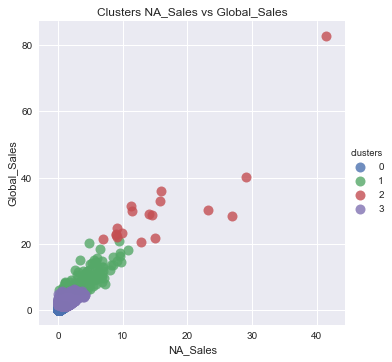

In [77]:
#Scatter plot of NA_Sales and Global_Sales
sns.lmplot('NA_Sales', 'Global_Sales', 
           data=vgKMeansNew, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters NA_Sales vs Global_Sales')
plt.xlabel('NA_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

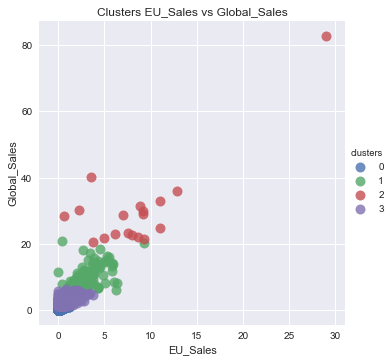

In [75]:
#Scatter plot of EU_Sales and Global_Sales
sns.lmplot('EU_Sales', 'Global_Sales', 
           data=vgKMeansNew, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters EU_Sales vs Global_Sales')
plt.xlabel('EU_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

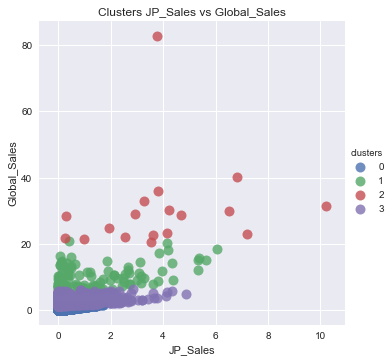

In [78]:
#Scatter plot of JP_Sales and Global_Sales
sns.lmplot('JP_Sales', 'Global_Sales', 
           data=vgKMeansNew, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters JP_Sales vs Global_Sales')
plt.xlabel('JP_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

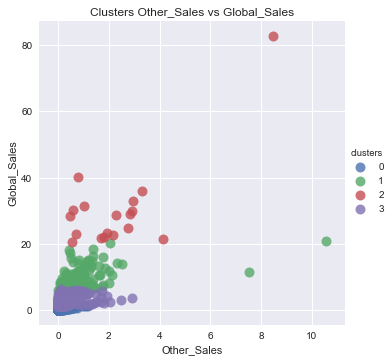

In [79]:
#Scatter plot of Other_Sales and Global_Sales
sns.lmplot('Other_Sales', 'Global_Sales', 
           data=vgKMeansNew, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Other_Sales vs Global_Sales')
plt.xlabel('Other_Sales')
plt.ylabel('Global_Sales')

#### Scaling

In [109]:
clmnsNew=['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']

In [110]:
#Scaling
vgKMeans_normalized = preprocessing.normalize(vgKMeans[clmnsNew], norm='l2')
vgKMeansScaling=pd.DataFrame(vgKMeans_normalized,columns=clmnsNew)
vgKMeansScaling

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
0      0.425784  0.297813  0.038689     0.086819      0.849106
1      0.578749  0.071249  0.135532     0.015325      0.800855
2      0.381488  0.310004  0.091220     0.079667      0.862379
3      0.409706  0.286404  0.085323     0.076999      0.858432
4      0.313032  0.246926  0.283867     0.027776      0.871600
5      0.603635  0.058802  0.109799     0.015091      0.787327
6      0.333274  0.270309  0.190358     0.084929      0.878870
7      0.415575  0.272508  0.086788     0.084418      0.859289
8      0.438227  0.212055  0.141170     0.067882      0.859333
9      0.689070  0.016120  0.007164     0.012026      0.724380
10     0.315373  0.382481  0.067108     0.095620      0.860582
11     0.364775  0.281483  0.153570     0.071393      0.871221
12     0.339035  0.232804  0.271228     0.026746      0.869814
13     0.343292  0.308348  0.138238     0.082559      0.872437
14     0.356533  0.336922  0.099233     0.070208      0.862897
15     0.555030  0.183156  0.008898     0.061917      0.809001
16     0.283667  0.375121  0.039252     0.167530      0.865570
17     0.374503  0.015886  0.016283     0.419777      0.826449
18     0.515168  0.151164  0.142699     0.022171      0.831202
19     0.204660  0.398980  0.179239     0.088327      0.871207
20     0.307206  0.216288  0.289022     0.065556      0.878073
21     0.498839  0.124825  0.192534     0.019346      0.835544
22     0.467512  0.168579  0.188181     0.022542      0.846814
23     0.486920  0.268488  0.003034     0.069777      0.828218
24     0.440151  0.287328  0.024598     0.093159      0.845237
25     0.332569  0.214029  0.295251     0.027440      0.869289
26     0.316825  0.186568  0.321375     0.046642      0.871411
27     0.197185  0.307241  0.304948     0.067639      0.877013
28     0.394321  0.293006  0.107647     0.066775      0.861749
29     0.505206  0.239455  0.007273     0.073851      0.825785
...         ...       ...       ...          ...           ...
16261  0.000000  0.000000  0.707107     0.000000      0.707107
16262  0.707107  0.000000  0.000000     0.000000      0.707107
16263  0.000000  0.707107  0.000000     0.000000      0.707107
16264  0.000000  0.000000  0.707107     0.000000      0.707107
16265  0.000000  0.000000  0.707107     0.000000      0.707107
16266  0.707107  0.000000  0.000000     0.000000      0.707107
16267  0.000000  0.000000  0.707107     0.000000      0.707107
16268  0.000000  0.000000  0.707107     0.000000      0.707107
16269  0.000000  0.707107  0.000000     0.000000      0.707107
16270  0.000000  0.707107  0.000000     0.000000      0.707107
16271  0.707107  0.000000  0.000000     0.000000      0.707107
16272  0.707107  0.000000  0.000000     0.000000      0.707107
16273  0.000000  0.000000  0.707107     0.000000      0.707107
16274  0.000000  0.707107  0.000000     0.000000      0.707107
16275  0.707107  0.000000  0.000000     0.000000      0.707107
16276  0.707107  0.000000  0.000000     0.000000      0.707107
16277  0.707107  0.000000  0.000000     0.000000      0.707107
16278  0.707107  0.000000  0.000000     0.000000      0.707107
16279  0.000000  0.707107  0.000000     0.000000      0.707107
16280  0.000000  0.000000  0.707107     0.000000      0.707107
16281  0.707107  0.000000  0.000000     0.000000      0.707107
16282  0.000000  0.000000  0.707107     0.000000      0.707107
16283  0.000000  0.000000  0.707107     0.000000      0.707107
16284  0.707107  0.000000  0.000000     0.000000      0.707107
16285  0.707107  0.000000  0.000000     0.000000      0.707107
16286  0.707107  0.000000  0.000000     0.000000      0.707107
16287  0.707107  0.000000  0.000000     0.000000      0.707107
16288  0.000000  0.000000  0.000000     0.000000      0.000000
16289  0.000000  0.707107  0.000000     0.000000      0.707107
16290  0.707107  0.000000  0.000000     0.000000      0.707107

[16291 rows x 5 columns]

In [111]:
kmeansScaling = KMeans(n_clusters=4, random_state=0).fit(vgKMeansScaling)
labelsScaling = kmeansScaling.labels_
labelsScaling

array([2, 0, 2, ..., 2, 3, 0], dtype=int32)

In [112]:
#Glue back to originaal data
vgKMeansNew['cluster'] = labelsScaling

#Add the column into our list
clmnsNew.extend(['cluster'])

vgKMeansN=vgKMeansNew[clmnsNew]
vgKMeansN

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  cluster
0         41.49     29.02      3.77         8.46         82.74        2
1         29.08      3.58      6.81         0.77         40.24        0
2         15.85     12.88      3.79         3.31         35.83        2
3         15.75     11.01      3.28         2.96         33.00        2
4         11.27      8.89     10.22         1.00         31.38        2
5         23.20      2.26      4.22         0.58         30.26        0
6         11.38      9.23      6.50         2.90         30.01        2
7         14.03      9.20      2.93         2.85         29.01        2
8         14.59      7.06      4.70         2.26         28.61        2
9         26.93      0.63      0.28         0.47         28.31        0
10         9.07     11.00      1.93         2.75         24.75        2
11         9.81      7.57      4.13         1.92         23.43        2
12         9.00      6.18      7.20         0.71         23.09        2
13         8.94      8.03      3.60         2.15         22.72        2
14         9.09      8.59      2.53         1.79         22.00        2
15        14.97      4.94      0.24         1.67         21.82        0
16         7.01      9.27      0.97         4.14         21.39        2
17         9.43      0.40      0.41        10.57         20.81        2
18        12.78      3.75      3.54         0.55         20.62        0
19         4.75      9.26      4.16         2.05         20.22        2
20         6.42      4.52      6.04         1.37         18.35        2
21        10.83      2.71      4.18         0.42         18.14        0
22         9.54      3.44      3.84         0.46         17.28        2
23         9.63      5.31      0.06         1.38         16.38        2
24         8.41      5.49      0.47         1.78         16.15        2
25         6.06      3.90      5.38         0.50         15.84        2
26         5.57      3.28      5.65         0.82         15.32        2
27         3.44      5.36      5.32         1.18         15.30        2
28         6.85      5.09      1.87         1.16         14.97        2
29         9.03      4.28      0.13         1.32         14.76        2
...         ...       ...       ...          ...           ...      ...
16568      0.00      0.00      0.01         0.00          0.01        1
16569      0.01      0.00      0.00         0.00          0.01        0
16570      0.00      0.01      0.00         0.00          0.01        3
16571      0.00      0.00      0.01         0.00          0.01        1
16572      0.00      0.00      0.01         0.00          0.01        1
16573      0.01      0.00      0.00         0.00          0.01        0
16574      0.00      0.00      0.01         0.00          0.01        1
16575      0.00      0.00      0.01         0.00          0.01        1
16576      0.00      0.01      0.00         0.00          0.01        3
16577      0.00      0.01      0.00         0.00          0.01        3
16578      0.01      0.00      0.00         0.00          0.01        0
16579      0.01      0.00      0.00         0.00          0.01        0
16580      0.00      0.00      0.01         0.00          0.01        1
16581      0.00      0.01      0.00         0.00          0.01        3
16582      0.01      0.00      0.00         0.00          0.01        0
16583      0.01      0.00      0.00         0.00          0.01        0
16584      0.01      0.00      0.00         0.00          0.01        0
16585      0.01      0.00      0.00         0.00          0.01        0
16586      0.00      0.01      0.00         0.00          0.01        3
16587      0.00      0.00      0.01         0.00          0.01        1
16588      0.01      0.00      0.00         0.00          0.01        0
16589      0.00      0.00      0.01         0.00          0.01        1
16590      0.00      0.00      0.01         0.00          0.01        1
16591      0.01      0.00      0.00         0.0

In [105]:
#Lets analyze the clusters
kNew=vgKMeansN.groupby(['cluster']).mean()
kNew

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
cluster                                                         
0        0.311186  0.049363  0.013201     0.022438      0.396188
1        0.019057  0.009502  0.191540     0.004755      0.224855
2        0.462738  0.332246  0.087842     0.108201      0.991027
3        0.042378  0.228731  0.012287     0.050341      0.333737

Text(28.173,0.5,'Global_Sales')

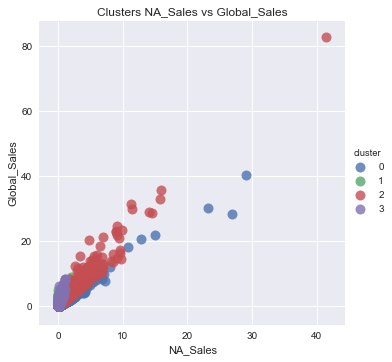

In [113]:
#Scatter plot of NA_Sales and Global_Sales
sns.lmplot('NA_Sales', 'Global_Sales', 
           data=vgKMeansN, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters NA_Sales vs Global_Sales')
plt.xlabel('NA_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

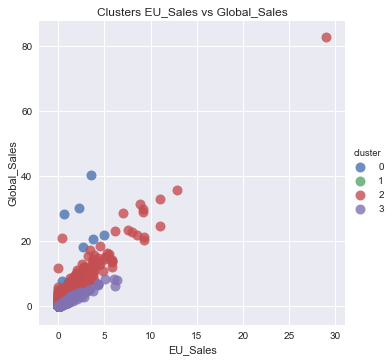

In [114]:
#Scatter plot of EU_Sales and Global_Sales
sns.lmplot('EU_Sales', 'Global_Sales', 
           data=vgKMeansN, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters EU_Sales vs Global_Sales')
plt.xlabel('EU_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

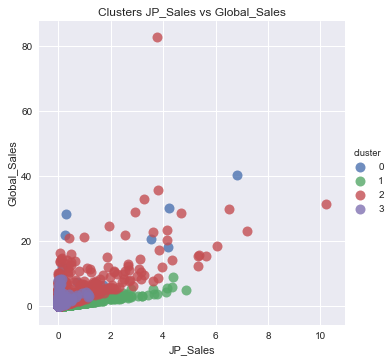

In [115]:
#Scatter plot of JP_Sales and Global_Sales
sns.lmplot('JP_Sales', 'Global_Sales', 
           data=vgKMeansN, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters JP_Sales vs Global_Sales')
plt.xlabel('JP_Sales')
plt.ylabel('Global_Sales')

Text(28.173,0.5,'Global_Sales')

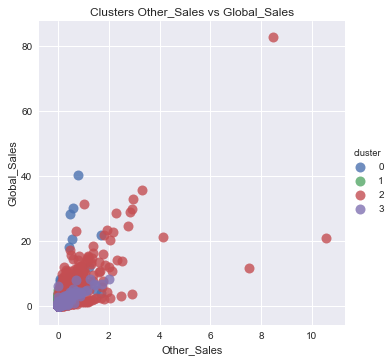

In [116]:
#Scatter plot of Other_Sales and Global_Sales
sns.lmplot('Other_Sales', 'Global_Sales', 
           data=vgKMeansN, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Other_Sales vs Global_Sales')
plt.xlabel('Other_Sales')
plt.ylabel('Global_Sales')

##### Does scaling effect the clustering? 
From the chart and results printed, it's apparent that scaling effects the clustering.
Comparing charts before scaling and after scaling, the boundary of each grouping is clearly different.
##### Does the clustering produce interesting groupings?
Yes. From the chart, we could see interesting groupings. 

Taking Clusters NA_Sales vs Global_Sales for example, it's clearly that in low global sales grouping, Global sales increases with NA sales increasing, which means NA sales affects global sales a lot. In grouping with high global sales, the weight of the influence of NA sales to global sales has dropped.
